<a href="https://colab.research.google.com/github/CyJavac/CIENCIA_DATOS_2025/blob/main/Apikey_LOL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
!pip install pandas requests

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Pregunta problema: ¿Qué tanto se acerca o se aleja de los valores de puntos de vision por minuto esperados en su rol de soporte?

In [54]:
import requests
import pandas as pd
from time import sleep
from datetime import datetime

# --- CONFIGURACIÓN ---
API_KEY = "RGAPI-51f94f56-b7a1-4b12-a0e5-e28cb2518aca"
RIOT_ID = "Arumah"
TAG_LINE = "Aruh"
HEADERS = {"X-Riot-Token": API_KEY}

In [55]:
!GET https://<region>.api.riotgames.com/lol/match/v5/matches/<matchId>

/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `GET https://<region>.api.riotgames.com/lol/match/v5/matches/<matchId>'


In [56]:
# Obtener el Puuid del jugador
def get_puuid(game_name, tag_line):
    url = f"https://americas.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{game_name}/{tag_line}"
    try:
        response = requests.get(url, headers=HEADERS, timeout=10)
        response.raise_for_status()
        return response.json()["puuid"]
    except Exception as e:
        print(f"Error al obtener PUUID: {str(e)}")
        return None

# Obtener Historial de las partidas
def get_match_history(puuid, count=10, start=0):
    url = f"https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?start={start}&count={count}"
    try:
        response = requests.get(url, headers=HEADERS, timeout=10)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f" Error al obtener historial: {str(e)}")
        return None

In [57]:
# Datos de la partida
def get_match_details(match_id):
    url = f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}"
    try:
        response = requests.get(url, headers=HEADERS, timeout=10)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f" Error en match {match_id}: {str(e)}")
        return None


# --- Obtener datos extendidos ---
def get_extended_data(match_id, puuid):
    match_data = get_match_details(match_id)
    if not match_data:
        return None

    try:
        participant = next(p for p in match_data["info"]["participants"] if p["puuid"] == puuid)

        return {
            # Datos base
            "puuid": puuid,
            "summoner_id": participant["summonerId"],
            "summoner_name": participant["summonerName"],
            # "date": match_data["info"]["gameCreation"],
            "date": datetime.fromtimestamp(match_data["info"]["gameCreation"] / 1000).strftime('%Y-%m-%d %H:%M:%S'),
            # "region": match_data["info"]["gameMode"],
            "game_mode": match_data["info"]["gameMode"],
            "game_id": match_data["metadata"]["matchId"],
            "match_id": match_id,
            "champion": participant["championName"],
            "win": participant["win"],
            "kills": participant["kills"],
            "deaths": participant["deaths"],
            "assists": participant["assists"],
            "kda": round((participant["kills"] + participant["assists"]) / max(1, participant["deaths"]), 2),
            "cs": participant["totalMinionsKilled"] + participant["neutralMinionsKilled"],
            "vision_score": participant["visionScore"],
            "gold_earned": participant["goldEarned"],
            "gold_spent": participant["goldSpent"],
            "total_damage_dealt": participant["totalDamageDealtToChampions"],
            "total_damage_taken": participant["totalDamageTaken"],
            "magic_damage_dealt": participant["magicDamageDealtToChampions"],
            "physical_damage_dealt": participant["physicalDamageDealtToChampions"],
            "true_damage_dealt": participant["trueDamageDealtToChampions"],
            "timeCCingOthers": participant["timeCCingOthers"],
            "total_minions_killed": participant["totalMinionsKilled"],
            "largest_killing_spree": participant["largestKillingSpree"],
            "largest_multi_kill": participant["largestMultiKill"],
            "killing_sprees": participant["killingSprees"],
            "perks": participant["perks"],
            "longest_time_spent_living": participant["longestTimeSpentLiving"],
            "total_units_healed": participant["totalUnitsHealed"],
            "totalTimeSpentDead": participant["totalTimeSpentDead"],
            "vision_wards_bought_in_game": participant["visionWardsBoughtInGame"],
            "game_duration": match_data["info"]["gameDuration"] // 60,
            "queue_id": match_data["info"]["queueId"],
            "team_position": participant["teamPosition"],
            "lane": participant["lane"],
            "role": participant["role"],
            "level": participant["champLevel"],
            "game_version": match_data["info"]["gameVersion"],
            "map_id": match_data["info"]["mapId"],
            "game_name": match_data["info"]["gameName"],
            "game_creation": match_data["info"]["gameCreation"],
            "game_version": match_data["info"]["gameVersion"],
            "game_type": match_data["info"]["gameType"],
            "platform_id": match_data["info"]["platformId"],
            "participants": match_data["info"]["participants"],
            "teams": match_data["info"]["teams"],
            "items": [participant[f"item{i}"] for i in range(7)],
            "summoner_spells": [participant["summoner1Id"], participant["summoner2Id"]],
            "damage_to_champs": participant["totalDamageDealtToChampions"],
            "damage_taken": participant["totalDamageTaken"],
            "dragons_killed": participant["dragonKills"],
            "barons_killed": participant["baronKills"],
            "turret_kills": participant["turretKills"],
            "wards_placed": participant["wardsPlaced"],
            "wards_destroyed": participant["wardsKilled"],
            "vision_score_per_min": participant["visionScore"] / max(1, (match_data["info"]["gameDuration"] / 60)),
        }
    except Exception as e:
        print(f"Error procesando {match_id}: {str(e)}")
        return None

In [58]:
# --- EJECUCIÓN PRINCIPAL ---
print("Iniciando extracción...")
puuid = get_puuid(RIOT_ID, TAG_LINE)

if puuid:
    print(f"PUUID obtenido: {puuid}")
    match_ids = get_match_history(puuid, count=100)  # Deberia de poderse aumentar el count, pero tal parece que riot solo guarda las ultimas 100 partidas

    if match_ids:
        all_matches = []
        for match_id in match_ids:
            match_data = get_extended_data(match_id, puuid)
            if match_data:
                all_matches.append(match_data)
            sleep(1.5)  # Respeta el rate limit

        df = pd.DataFrame(all_matches)

        # Guardar en Excel
        filename = f"lol_data_{RIOT_ID}.xlsx"
        df.to_excel(filename, index=False)
        print(f"Datos guardados en '{filename}'")

        # Descargar automáticamente en Colab
        try:
            from google.colab import files
            files.download(filename)
            print("Archivo descargado!")
        except:
            print("Ejecutando localmente - revisa el archivo en tu directorio")
    else:
        print(" No se encontraron partidas")
else:
    print("No se pudo obtener PUUID - Verifica:")
    print(f"- API Key (¿generada en las últimas 24 horas?)")
    print(f"- Riot ID: '{RIOT_ID}#{TAG_LINE}' (¿existe?)")

Iniciando extracción...
PUUID obtenido: PpDPLDsNjJy2H_hEnquPP9Q_3iknFPsl0Pxl3ZPeSD_d4HXpPEkzkatUc1G-M5481NCPaRKF3R-ABQ
Datos guardados en 'lol_data_Arumah.xlsx'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Archivo descargado!


In [59]:
import requests
import pandas as pd

# --- CONFIGURACIÓN ---
API_KEY = "RGAPI-51f94f56-b7a1-4b12-a0e5-e28cb2518aca"  # Reemplazar si expiró
HEADERS = {"X-Riot-Token": API_KEY}

def get_match_details(match_id):
    url = f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}"
    try:
        response = requests.get(url, headers=HEADERS, timeout=10)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"Error en detalles del match: {str(e)}")
        return None

def get_match_timeline(match_id):
    url = f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}/timeline"
    try:
        response = requests.get(url, headers=HEADERS, timeout=10)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"Error en timeline del match: {str(e)}")
        return None

def get_player_positions(match_id, puuid):
    match_data = get_match_details(match_id)
    timeline = get_match_timeline(match_id)

    if not match_data or not timeline:
        return None

    # Encontrar participantId
    try:
        participant = next(p for p in match_data["info"]["participants"] if p["puuid"] == puuid)
        participant_id = participant["participantId"]
    except:
        print("No se encontró el participantId para ese puuid.")
        return None

    posiciones = []

    for frame in timeline["info"]["frames"]:
        timestamp = frame["timestamp"]
        try:
            pos = frame["participantFrames"][str(participant_id)]["position"]
            posiciones.append({
                "timestamp_ms": timestamp,
                "x": pos["x"],
                "y": pos["y"]
            })
        except KeyError:
            continue

    return pd.DataFrame(posiciones)

# --- EJECUCIÓN ---
match_id = "LA1_1651267630"  # Reemplazar con el match real
puuid = "PpDPLDsNjJy2H_hEnquPP9Q_3iknFPsl0Pxl3ZPeSD_d4HXpPEkzkatUc1G-M5481NCPaRKF3R-ABQ"  # El puuid del jugador

df_pos = get_player_positions(match_id, puuid)

if df_pos is not None:
    df_pos.to_excel("coordenadas_lol.xlsx", index=False)
    print("Coordenadas guardadas correctamente.")
else:
    print("No se pudo generar el DataFrame.")


Coordenadas guardadas correctamente.


In [60]:
df_pos

timestamp_ms      x      y
0              0  14281  14199
1          60003  13183   2007
2         120023  12684   2919
3         180111  13217   4566
4         240119  11850   4255
5         300124  12396   2297
6         360141  13737   3817
7         420161  12942   1954
8         480173   9599   5489
9         540199   3838   9960
10        600231  11846  10713
11        660255  11816   1500
12        720255  10625   2534
13        780266  13835   9146
14        840272  10492   3071
15        900283  10062   6958
16        960309   6836   6416
17       1020318  11672  11193
18       1080319  10772   3506
19       1140344   7661   1506
20       1200351   8294   8043
21       1260364   5512   8561
22       1320364   7603   1108
23       1380368  10936  10426
24       1440391  13685   6230
25       1500417   6600   9580
26       1560425  11147  11576
27       1620443  10220   5567
28       1680465  11371   3824
29       1740467   8298   3451
30       1800498   5844   9343
31       1860515   8856   9002
32       1920540   9002   8193
33       1980542  10374  10414
34       2040546  10200   5653
35       2100549  13426  14053
36       2102651  13426  14053

#Mapa de calor del movimiento del jugador

Generando mapa para Arumah#Aruh → LA1_1651267630
37 posiciones | 35 min


/usr/local/lib/python3.12/dist-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


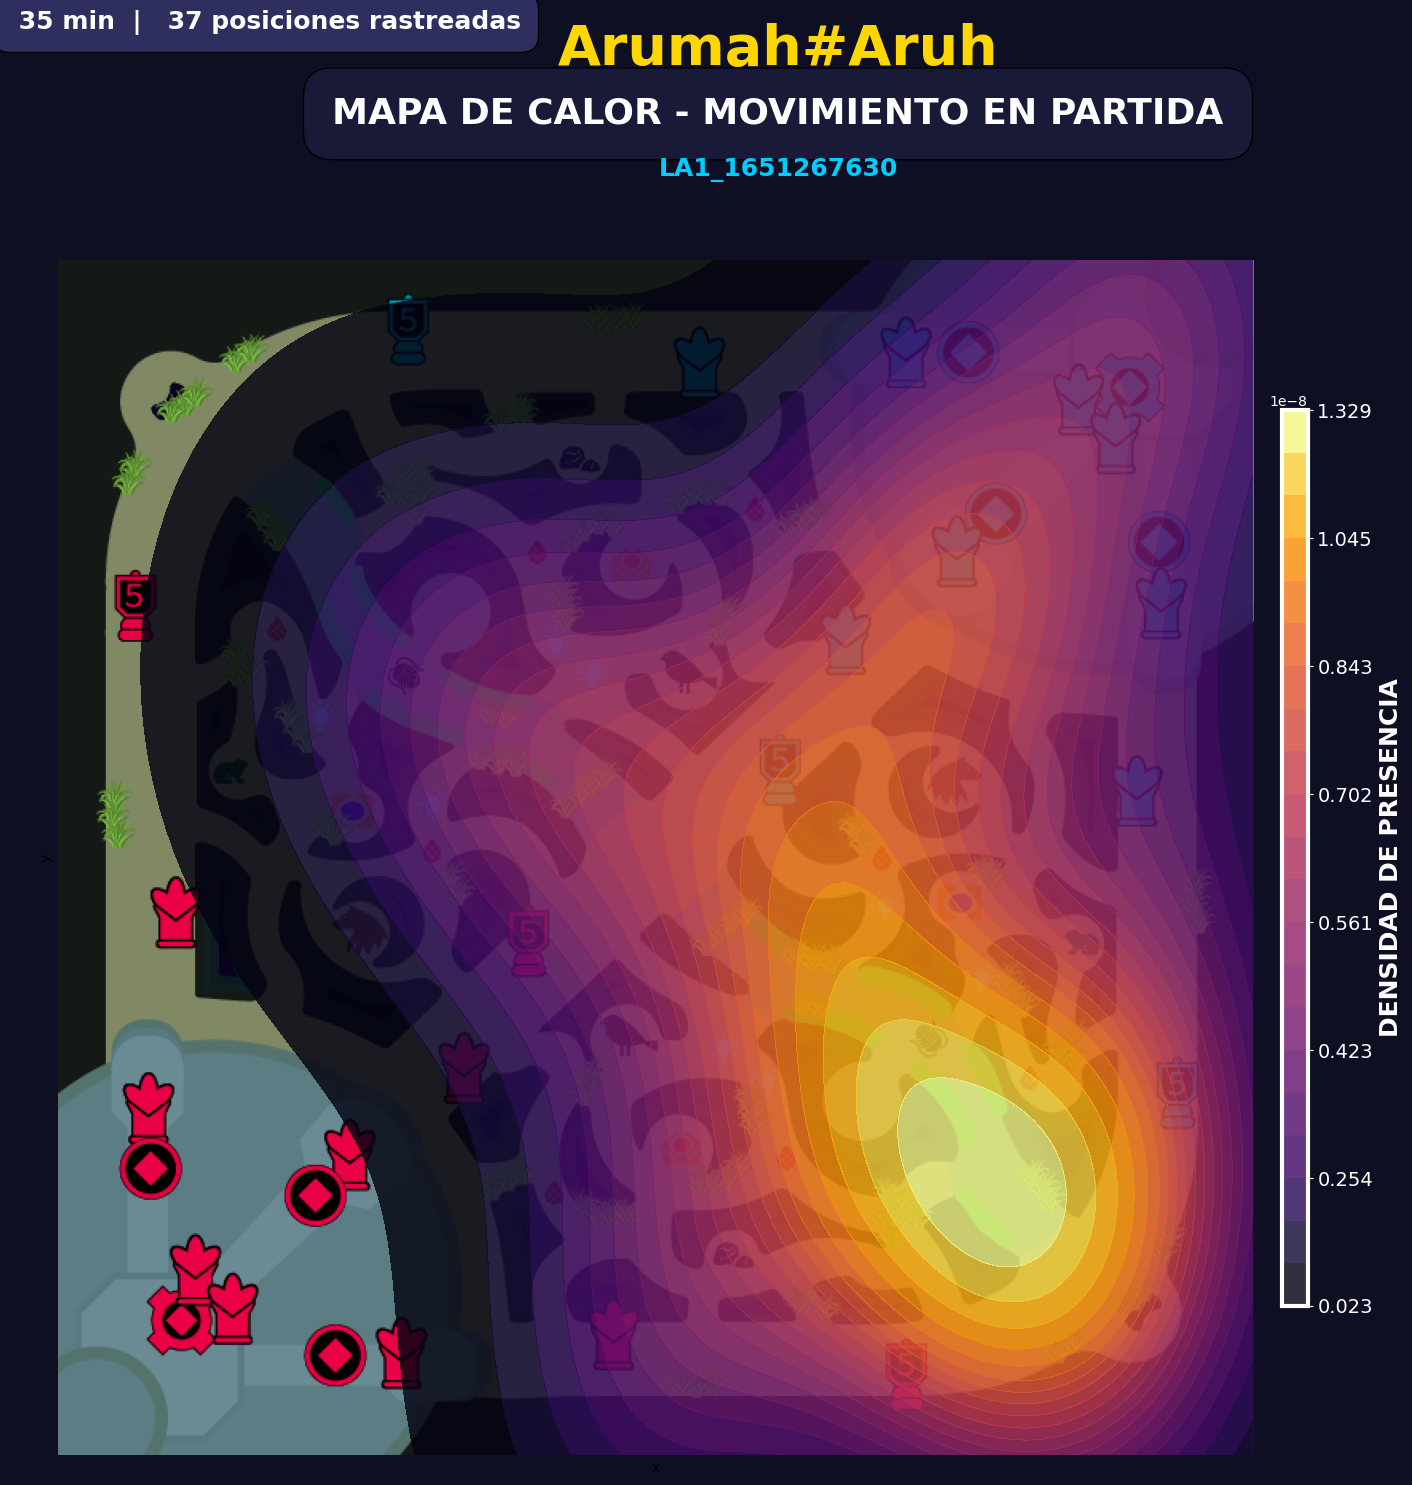

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


MAPA DESCARGADO → MAPA_CALOR_Arumah_Aruh_LA1_1651267630.png
Zonas BLANCAS = donde más estuviste
Zonas NEGRAS = nunca pasaste


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from google.colab import files


HEADERS = {"X-Riot-Token": API_KEY}
print(f"Generando mapa para {RIOT_ID}#{TAG_LINE} → {match_id}")

# ========================= OBTENER DATOS AUTOMÁTICO =========================
def get_timeline(match_id):
    url = f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}/timeline"
    r = requests.get(url, headers=HEADERS, timeout=15)
    return r.json() if r.status_code == 200 else None

def get_match(match_id):
    url = f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}"
    r = requests.get(url, headers=HEADERS, timeout=15)
    return r.json() if r.status_code == 200 else None

# PUUID
try:
    df_main = pd.read_excel('lol_data_Arumah.xlsx')
    puuid = df_main['puuid'].iloc[0]
except:
    url = f"https://americas.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{RIOT_ID}/{TAG_LINE}"
    puuid = requests.get(url, headers=HEADERS).json()['puuid']

# Timeline + Match
timeline = get_timeline(match_id)
match = get_match(match_id)
if not timeline or not match:
    print("Error: No se pudo cargar timeline/match. Revisa API_KEY o match_id")
    exit()

# Participant ID
part_id = next(p["participantId"] for p in match["info"]["participants"] if p["puuid"] == puuid)

# Extraer posiciones
pos = []
for frame in timeline["info"]["frames"]:
    try:
        p = frame["participantFrames"][str(part_id)]["position"]
        pos.append({'x': p['x'], 'y': p['y']})
    except: continue

df_pos = pd.DataFrame(pos)
duration_min = match["info"]["gameDuration"] // 60
print(f"{len(df_pos)} posiciones | {duration_min} min")

# ========================= GRÁFICA FINAL =========================
fig = plt.figure(figsize=(16, 16))
fig.patch.set_facecolor('#0f0f23')
ax = plt.subplot(111)
ax.set_facecolor('#0f0f23')

# Mapa fondo
try:
    mapa = plt.imread('/content/drive/MyDrive/8vo Semestre/Fundamentos ciencia de datos/Datos LOL/mapa_LoL.png')
    ax.imshow(mapa, extent=[0, 15000, 0, 15000], alpha=0.92, zorder=0)
except:
    ax.text(7500, 7500, 'mapa_LoL.png\nNO ENCONTRADO', ha='center', va='center',
            fontsize=30, color='#333333', fontweight='bold')

# Heatmap
sns.kdeplot(data=df_pos, x='x', y='y', ax=ax, levels=22, fill=True,
            cmap='inferno', alpha=0.82, thresh=0.01, linewidths=0)

# Límites
ax.set_xlim(0, 15000)
ax.set_ylim(0, 15000)
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

# ===================== TÍTULOS =====================
# Nombre del jugador (arriba centro)
fig.text(0.5, 0.955, f'{RIOT_ID}#{TAG_LINE}',
         ha='center', va='center', fontsize=40, fontweight='bold',
         color='#FFD700', transform=fig.transFigure)

# Título principal
fig.text(0.5, 0.915, 'MAPA DE CALOR - MOVIMIENTO EN PARTIDA',
         ha='center', va='center', fontsize=26, color='white',
         fontweight='bold', transform=fig.transFigure,
         bbox=dict(boxstyle="round,pad=0.8", facecolor='#1a1a3a', alpha=0.95))

# Match ID
fig.text(0.5, 0.88, match_id,
         ha='center', va='center', fontsize=18, color='#00CCFF',
         fontweight='bold', transform=fig.transFigure)

# Stats esquina superior izquierda
fig.text(0.02, 0.98, f' {duration_min} min  |   {len(df_pos):,} posiciones rastreadas',
         ha='left', va='top', fontsize=18, color='white', fontweight='bold',
         transform=fig.transFigure,
         bbox=dict(boxstyle="round,pad=0.7", facecolor='#333366', alpha=0.9))

# Colorbar
cbar = plt.colorbar(ax.collections[0], ax=ax, shrink=0.7, pad=0.02, aspect=35)
cbar.set_label('DENSIDAD DE PRESENCIA', fontsize=18, color='white', fontweight='bold')
cbar.ax.tick_params(colors='white', labelsize=14)
cbar.outline.set_edgecolor('white')
cbar.outline.set_linewidth(3)

# ===================== GUARDAR Y DESCARGAR =====================
filename = f'MAPA_CALOR_{RIOT_ID}_{TAG_LINE}_{match_id}.png'
plt.subplots_adjust(top=0.85, bottom=0.05, left=0.05, right=0.95)
plt.savefig(filename, dpi=400, bbox_inches='tight', facecolor='#0f0f23')
plt.show()

files.download(filename)
print(f"\nMAPA DESCARGADO → {filename}")
print("Zonas BLANCAS = donde más estuviste")
print("Zonas NEGRAS = nunca pasaste")

#Vision por minuto

El Vision Score es una métrica que Riot diseñó para resumir el impacto de la visión de un jugador en una partida.

No es solo “wards puestos”, sino una combinación de varias acciones que contribuyen a la visión.
* Colocar wards (y que estén activos un tiempo razonable).

* Destruir wards enemigos.

* Revelar enemigos con habilidades, control de visión.

* Asistir en kills poco después de que un ward colocó visión del enemigo.

* El puntaje escala con la duración del ward, la importancia de la visión creada y la oportunidad estratégica.

Basicamente, es cuánto impacta la visión de un jugador en el control del mapa durante toda la partida.

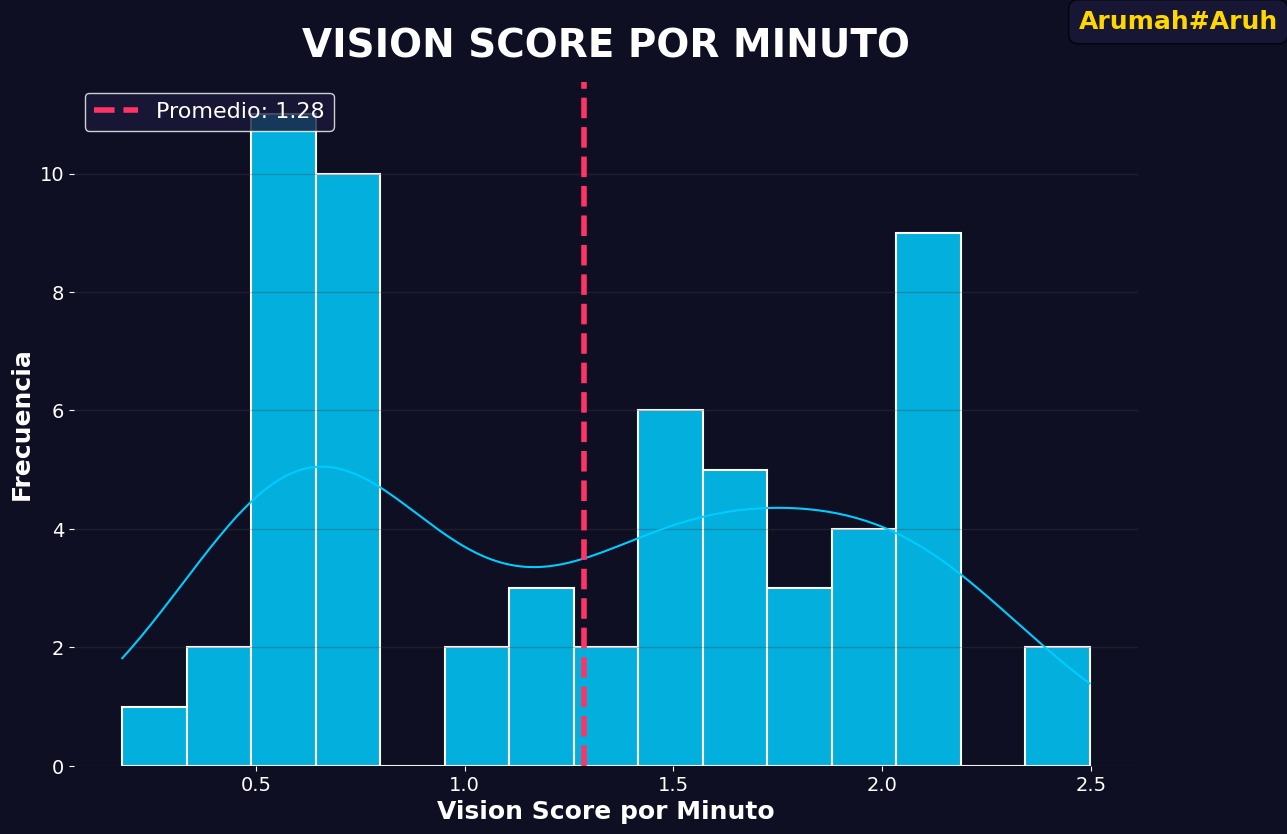

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


HISTOGRAMA DESCARGADO → HISTOGRAMA_VSmin_Arumah_Aruh.png


In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# ========================= DATOS =========================
if "vision_score_per_min" not in df.columns:
    df["vision_score_per_min"] = df["vision_score"] / df["game_duration"].replace(0, 1)

df_filtered = df[df["vision_score_per_min"] > 0]
avg_vs_min = df_filtered["vision_score_per_min"].mean()

# ========================= GRÁFICA =========================
fig, ax = plt.subplots(figsize=(14, 9))
fig.patch.set_facecolor('#0f0f23')
ax.set_facecolor('#0f0f23')

# Histograma + KDE
sns.histplot(
    data=df_filtered,
    x="vision_score_per_min",
    bins=15,
    kde=True,
    color='#00CCFF',
    alpha=0.85,
    edgecolor='white',
    linewidth=1.5,
    ax=ax
)

# Línea promedio
ax.axvline(avg_vs_min, color='#FF3366', linestyle="--", linewidth=4,
           label=f'Promedio: {avg_vs_min:.2f}')

# TÍTULO PRINCIPAL (centrado, sin fondo)
fig.text(0.5, 0.92, 'VISION SCORE POR MINUTO',
         ha='center', va='center', fontsize=28, fontweight='bold',
         color='white', transform=fig.transFigure)

# NOMBRE DEL JUGADOR → ESQUINA SUPERIOR DERECHA
fig.text(0.98, 0.96, f'{RIOT_ID}#{TAG_LINE}',
         ha='right', va='top', fontsize=18, fontweight='bold',
         color='#FFD700', transform=fig.transFigure,
         bbox=dict(boxstyle="round,pad=0.4", facecolor='#1a1a3a', alpha=0.8))

# Ejes
ax.set_xlabel('Vision Score por Minuto', fontsize=18, color='white', fontweight='bold')
ax.set_ylabel('Frecuencia', fontsize=18, color='white', fontweight='bold')
ax.tick_params(colors='white', labelsize=14)

# Grid sutil
ax.grid(True, axis='y', alpha=0.3, color='#444444', linewidth=1)

# Leyenda
ax.legend(fontsize=16, facecolor='#1a1a3a', edgecolor='white', labelcolor='white',
          loc='upper left')

# Sin bordes
for spine in ax.spines.values():
    spine.set_visible(False)

# Ajuste perfecto
plt.subplots_adjust(top=0.88, bottom=0.12, left=0.12, right=0.88)

# Guardar + descargar
filename = f'HISTOGRAMA_VSmin_{RIOT_ID}_{TAG_LINE}.png'
plt.savefig(filename, dpi=400, bbox_inches='tight', facecolor='#0f0f23')
plt.show()

files.download(filename)
print(f"\nHISTOGRAMA DESCARGADO → {filename}")

####Conclusión
El VS/min promedio de todas las partidas fue de 1.11, por debajo de lo recomendado para un soporte. La variación es normal debido a que otros roles distintos a soporte no se centran en dar visión.

#VS/min solo UTILITY

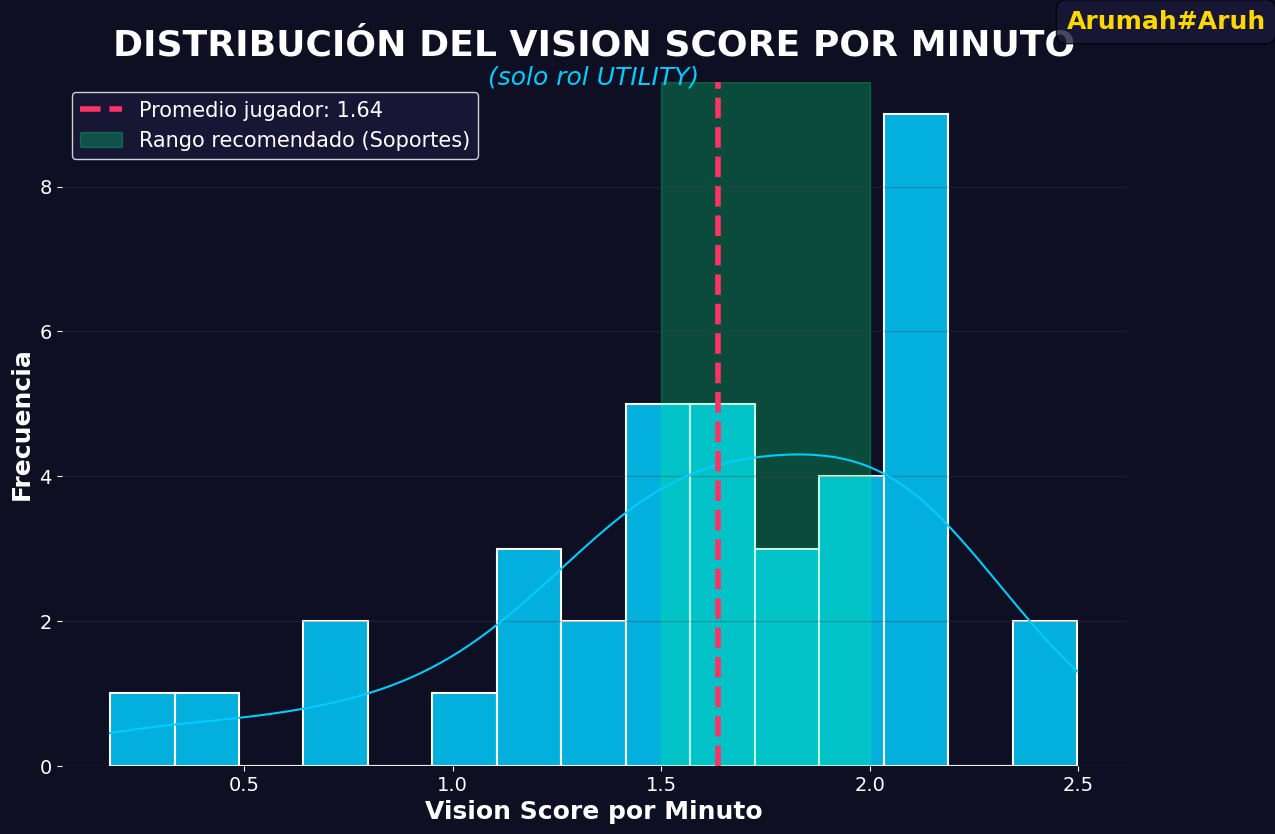

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


HISTOGRAMA SUPPORT DESCARGADO → HISTOGRAMA_SUPPORT_VSmin_Arumah_Aruh.png


In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# ========================= DATOS =========================
if "vision_score_per_min" not in df.columns:
    df["vision_score_per_min"] = df["vision_score"] / df["game_duration"].replace(0, 1)

df_supports = df[df["team_position"] == "UTILITY"].copy()
df_supports = df_supports[df_supports["vision_score_per_min"] > 0]
avg_vs_min = df_supports["vision_score_per_min"].mean()

# ========================= GRÁFICA FINAL =========================
fig, ax = plt.subplots(figsize=(14, 9))
fig.patch.set_facecolor('#0f0f23')
ax.set_facecolor('#0f0f23')

# Histograma + KDE
sns.histplot(
    data=df_supports,
    x="vision_score_per_min",
    bins=15,
    kde=True,
    color='#00CCFF',
    alpha=0.85,
    edgecolor='white',
    linewidth=1.5,
    ax=ax
)

# Línea promedio jugador
ax.axvline(avg_vs_min, color='#FF3366', linestyle="--", linewidth=4,
           label=f'Promedio jugador: {avg_vs_min:.2f}')

# Rango recomendado (1.5–2.0)
ax.axvspan(1.5, 2.0, color='#00FF88', alpha=0.25, label="Rango recomendado (Soportes)")

# TÍTULO PRINCIPAL
fig.text(0.5, 0.92, 'DISTRIBUCIÓN DEL VISION SCORE POR MINUTO',
         ha='center', va='center', fontsize=26, fontweight='bold',
         color='white', transform=fig.transFigure)

fig.text(0.5, 0.885, '(solo rol UTILITY)',
         ha='center', va='center', fontsize=18, color='#00CCFF',
         fontstyle='italic', transform=fig.transFigure)

# NOMBRE EN ESQUINA SUPERIOR DERECHA
fig.text(0.98, 0.96, f'{RIOT_ID}#{TAG_LINE}',
         ha='right', va='top', fontsize=18, fontweight='bold',
         color='#FFD700', transform=fig.transFigure,
         bbox=dict(boxstyle="round,pad=0.4", facecolor='#1a1a3a', alpha=0.8))

# Ejes
ax.set_xlabel('Vision Score por Minuto', fontsize=18, color='white', fontweight='bold')
ax.set_ylabel('Frecuencia', fontsize=18, color='white', fontweight='bold')
ax.tick_params(colors='white', labelsize=14)

# Grid
ax.grid(True, axis='y', alpha=0.3, color='#444444', linewidth=1)

# Leyenda
ax.legend(fontsize=15, facecolor='#1a1a3a', edgecolor='white', labelcolor='white',
          loc='upper left')

# Sin bordes
for spine in ax.spines.values():
    spine.set_visible(False)

# Ajuste perfecto
plt.subplots_adjust(top=0.88, bottom=0.12, left=0.12, right=0.88)

# Guardar + descargar
filename = f'HISTOGRAMA_SUPPORT_VSmin_{RIOT_ID}_{TAG_LINE}.png'
plt.savefig(filename, dpi=400, bbox_inches='tight', facecolor='#0f0f23')
plt.show()

files.download(filename)
print(f"\nHISTOGRAMA SUPPORT DESCARGADO → {filename}")

####Conslusión
Al filtrar solo las partidas en rol UTILITY, el promedio sube a 1.60 VS/min, entrando en el rango mínimo aceptable para soportes en Platino, pero algo lejos del estándar de soportes de utilidad (2.25–2.75 en rangos Challenger).

#VS/min comparado con otros jugadores

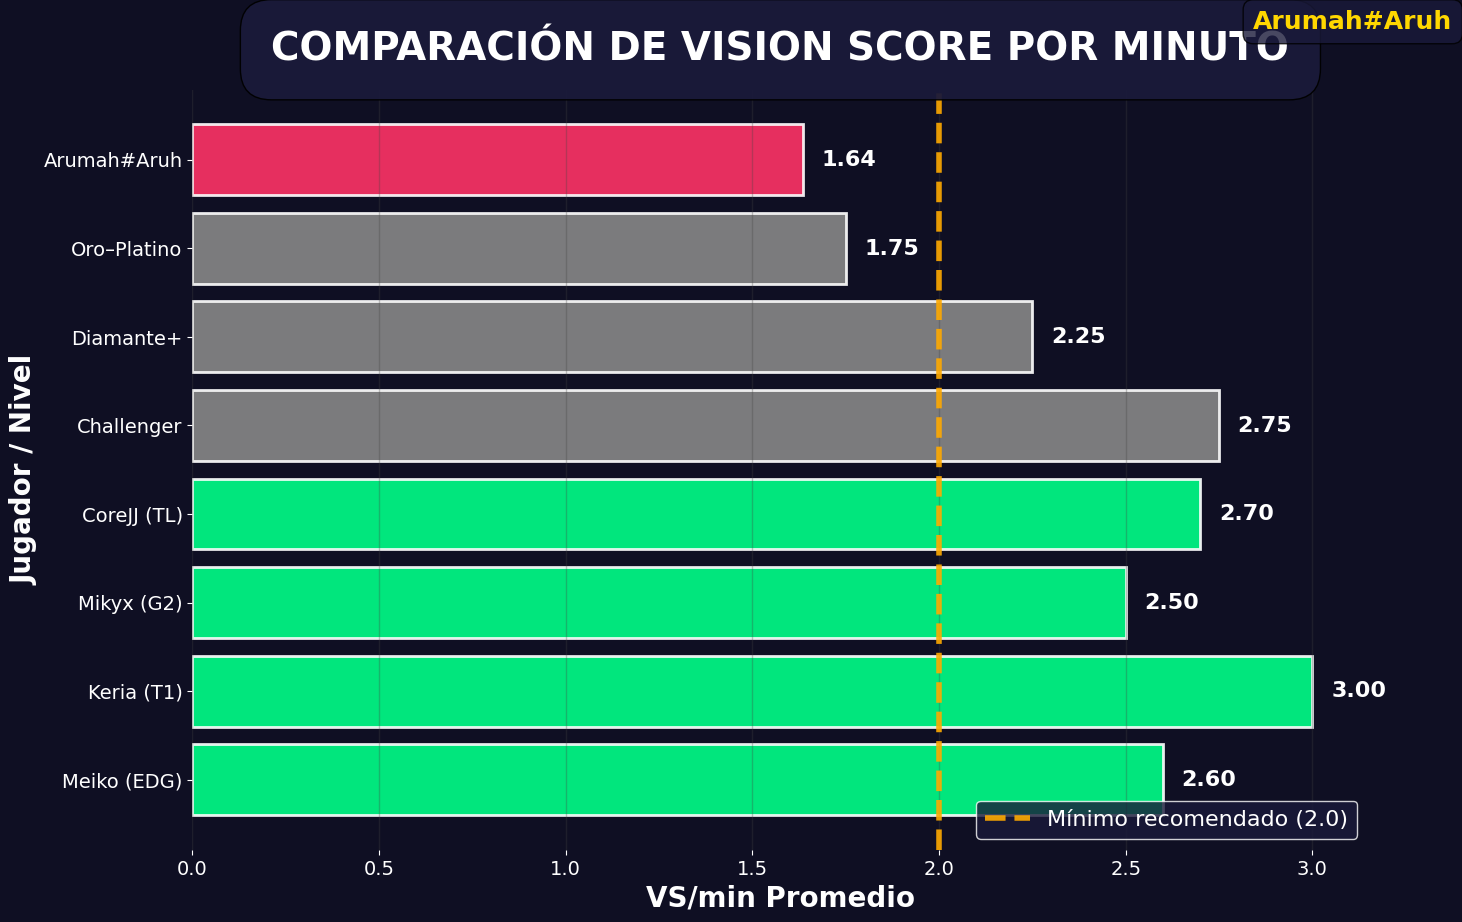

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


COMPARACIÓN DESCARGADA → COMPARACION_VSmin_Arumah_Aruh.png


In [64]:
import matplotlib.pyplot as plt
from google.colab import files

# ========================= DATOS =========================
players = [
    f"{RIOT_ID}#{TAG_LINE}",
    "Oro–Platino",
    "Diamante+",
    "Challenger",
    "CoreJJ (TL)",
    "Mikyx (G2)",
    "Keria (T1)",
    "Meiko (EDG)"
]

vs_min = [
    avg_vs_min,   # Jugador
    1.75,         # Oro–Platino
    2.25,         # Diamante+
    2.75,         # Challenger
    2.7,          # CoreJJ
    2.5,          # Mikyx
    3.0,          # Keria
    2.6           # Meiko
]

# ========================= GRÁFICA PRO =========================
fig, ax = plt.subplots(figsize=(14, 10))
fig.patch.set_facecolor('#0f0f23')
ax.set_facecolor('#0f0f23')

# Barras horizontales
colors = ['#FF3366', '#888888', '#888888', '#888888', '#00FF88', '#00FF88', '#00FF88', '#00FF88']
bars = ax.barh(players, vs_min, color=colors, alpha=0.9, edgecolor='white', linewidth=2)

# Línea referencia
ax.axvline(2.0, color='#FFAA00', linestyle="--", linewidth=4,
           label="Mínimo recomendado (2.0)", alpha=0.9)

# Valores en barras
for bar, value in zip(bars, vs_min):
    ax.text(value + 0.05, bar.get_y() + bar.get_height()/2,
            f"{value:.2f}", va='center', fontsize=16, fontweight='bold', color='white')

# TÍTULO PRINCIPAL
fig.text(0.5, 0.92, 'COMPARACIÓN DE VISION SCORE POR MINUTO',
         ha='center', va='center', fontsize=28, fontweight='bold',
         color='white', transform=fig.transFigure,
         bbox=dict(boxstyle="round,pad=0.8", facecolor='#1a1a3a', alpha=0.95))

# NOMBRE EN ESQUINA SUPERIOR DERECHA
fig.text(0.98, 0.96, f'{RIOT_ID}#{TAG_LINE}',
         ha='right', va='top', fontsize=18, fontweight='bold',
         color='#FFD700', transform=fig.transFigure,
         bbox=dict(boxstyle="round,pad=0.4", facecolor='#1a1a3a', alpha=0.8))

# Ejes
ax.set_xlabel('VS/min Promedio', fontsize=20, color='white', fontweight='bold')
ax.set_ylabel('Jugador / Nivel', fontsize=20, color='white', fontweight='bold')
ax.tick_params(colors='white', labelsize=14)
ax.invert_yaxis()  # Jugador arriba

# Grid
ax.grid(True, axis='x', alpha=0.3, color='#444444', linewidth=1)

# Leyenda
ax.legend(fontsize=16, facecolor='#1a1a3a', edgecolor='white', labelcolor='white',
          loc='lower right')

# Sin bordes
for spine in ax.spines.values():
    spine.set_visible(False)

# Ajuste perfecto
plt.subplots_adjust(top=0.88, bottom=0.12, left=0.08, right=0.92)

# Guardar + descargar
filename = f'COMPARACION_VSmin_{RIOT_ID}_{TAG_LINE}.png'
plt.savefig(filename, dpi=400, bbox_inches='tight', facecolor='#0f0f23')
plt.show()

files.download(filename)
print(f"\nCOMPARACIÓN DESCARGADA → {filename}")

####Conclusión
Mientras Arumah promedia 1.55 VS/min en rol soporte, jugadores Challenger y profesionales (CoreJJ, Keria, Mikyx, Meiko) alcanzan 2.5–3.0 VS/min de manera consistente.
Esto representa casi el doble de visión por minuto.

#VS/min según el tipo de soporte

In [65]:
#--- Listas de campeones por tipo ---

#1. Enchanters (curar, escudar, potenciar)
enchanters = ["Janna", "Karma", "Lulu", "Milio", "Nami", "RenataGlasc", "Senna",  "Seraphine", "Sona", "Soraka", "Taric", "Yuumi"]

#2. Engage / Tank Supports (iniciadores, tanques)
engage_tanks = ["Leona", "Nautilus", "Alistar", "Rell", "Braum", "Thresh", "Rakan", "TahmKench", "Galio"]

#3. Poke / Mage Supports (daño y hostigamiento)
poke_mages = ["Zyra", "Brand", "Xerath", "Velkoz", "Lux", "Morgana", "Hwei"]

#4. Peel Supports (protección y desenganche)
peel_supports = ["TahmKench", "Braum", "Janna", "Zilean", "Morgana"]

#5. Catch Supports (cazar picks)
catch_supports = ["Bard", "Blitzcrank", "Ivern", "Jhin", "Morgana", "Neeko", "Pyke", "Rakan", "Thresh", "Zyra"]


🎯 Generando 5 histogramas para Arumah#Aruh...

⚠️ No hay partidas para Soportes Enchanter


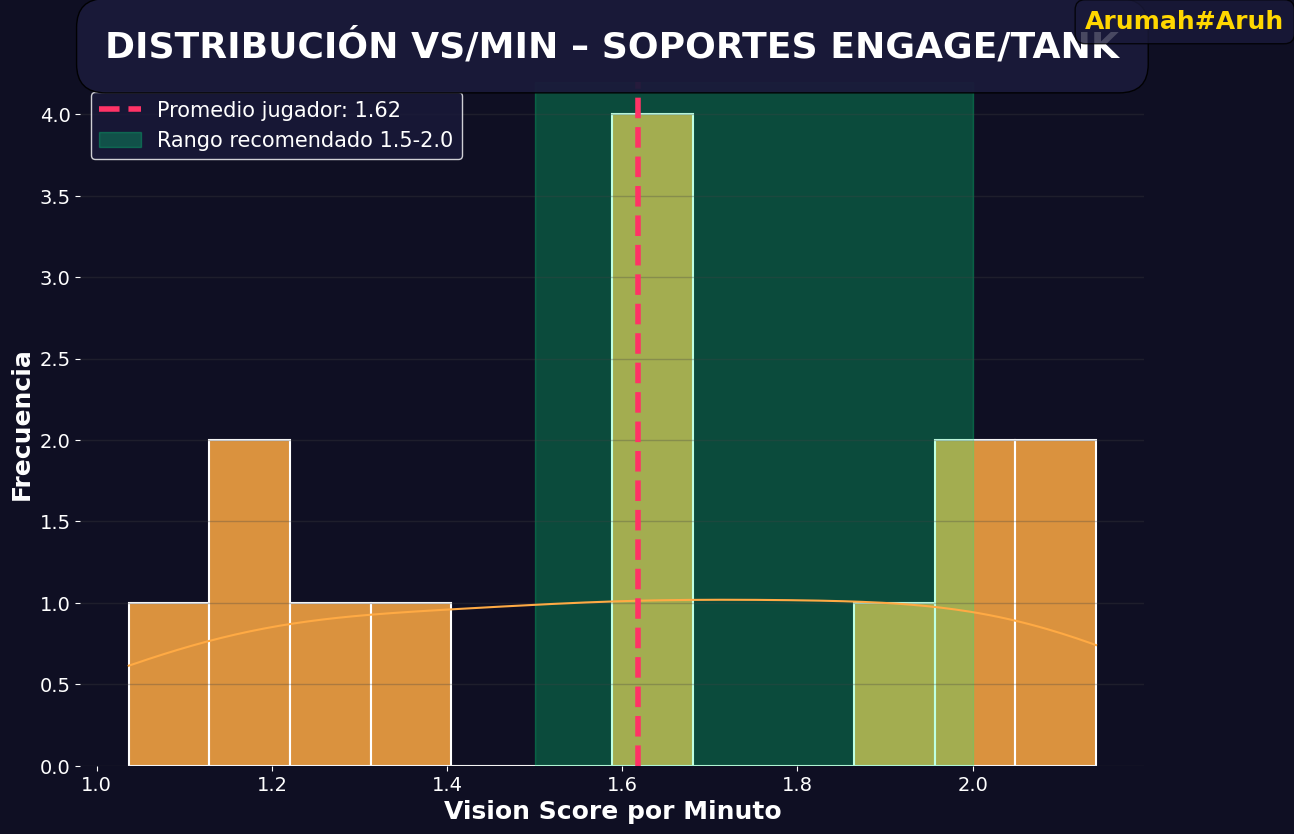

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📊 Soportes Engage/Tank DESCARGADO → HISTO_Soportes_Engage_Tank_Arumah_Aruh.png


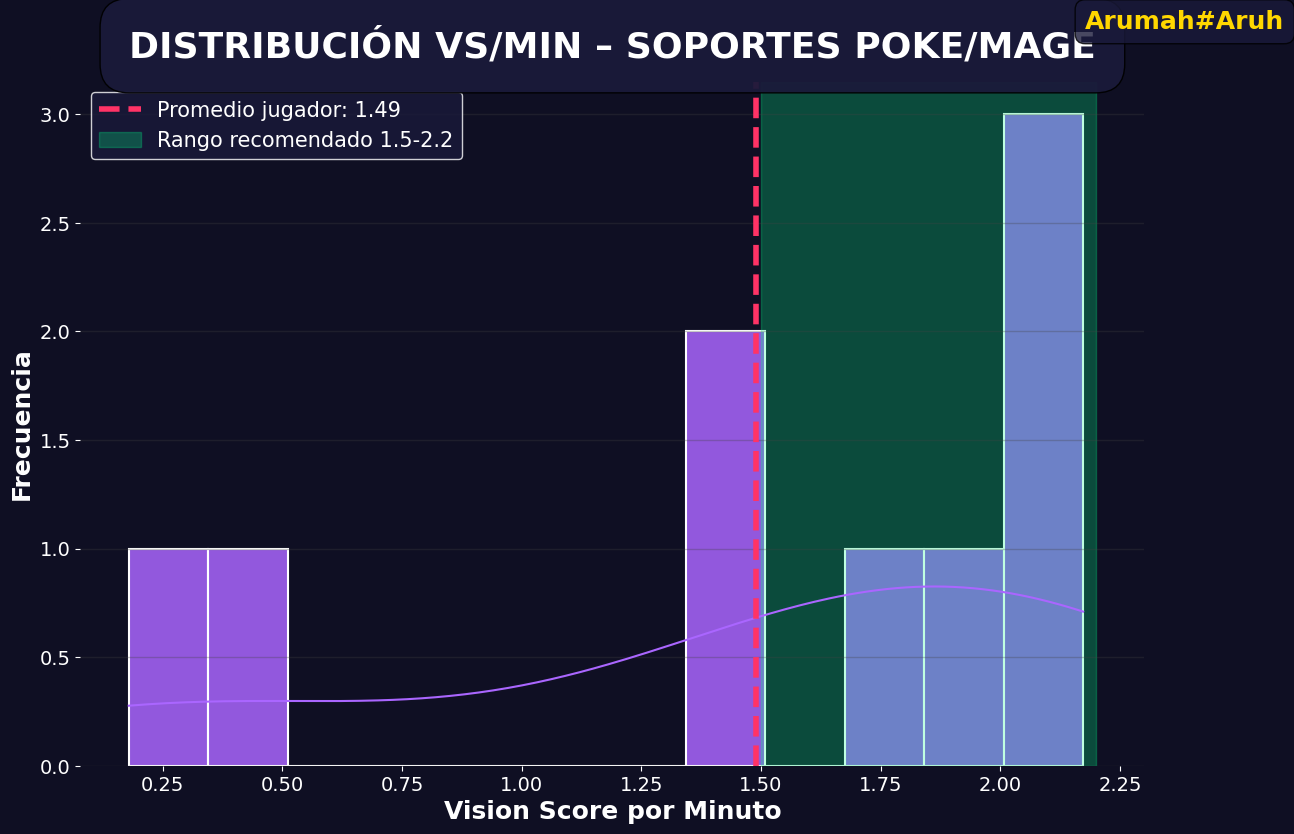

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📊 Soportes Poke/Mage DESCARGADO → HISTO_Soportes_Poke_Mage_Arumah_Aruh.png


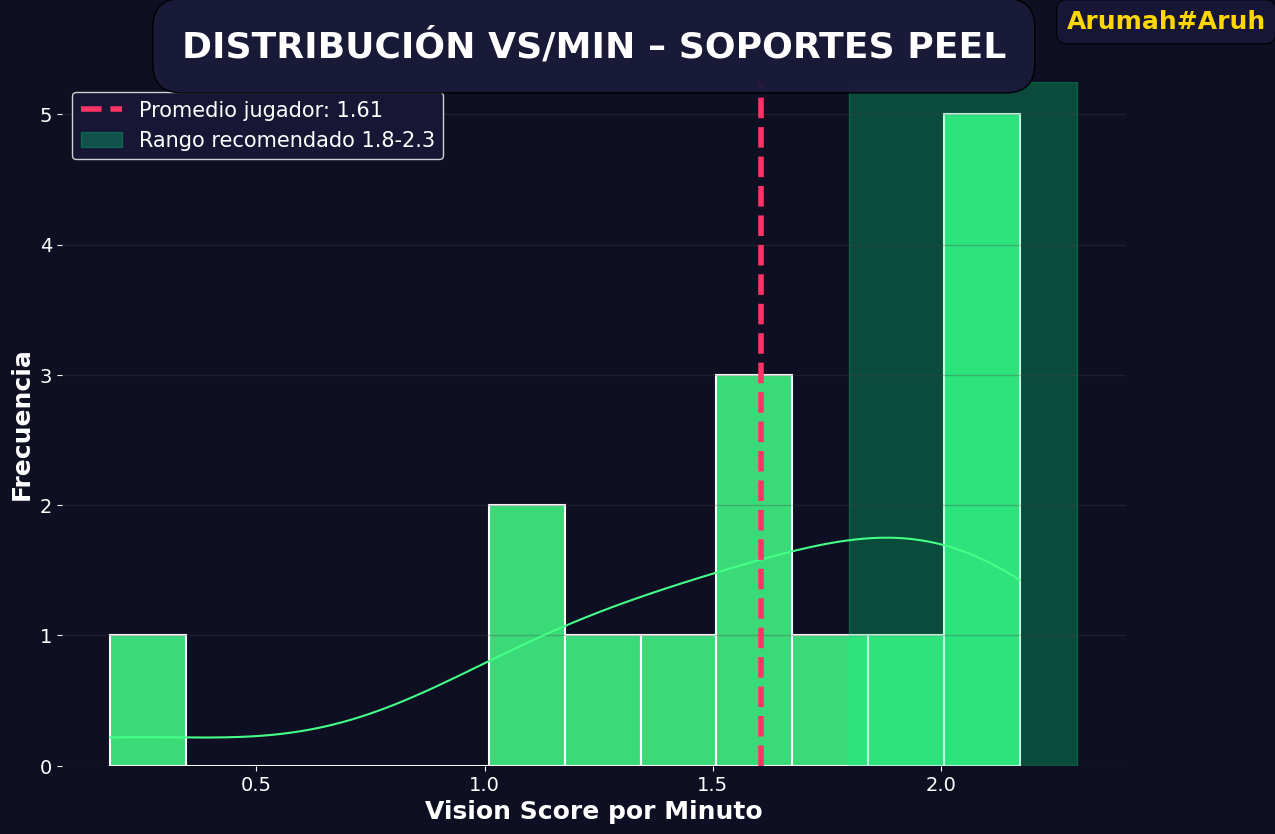

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📊 Soportes Peel DESCARGADO → HISTO_Soportes_Peel_Arumah_Aruh.png


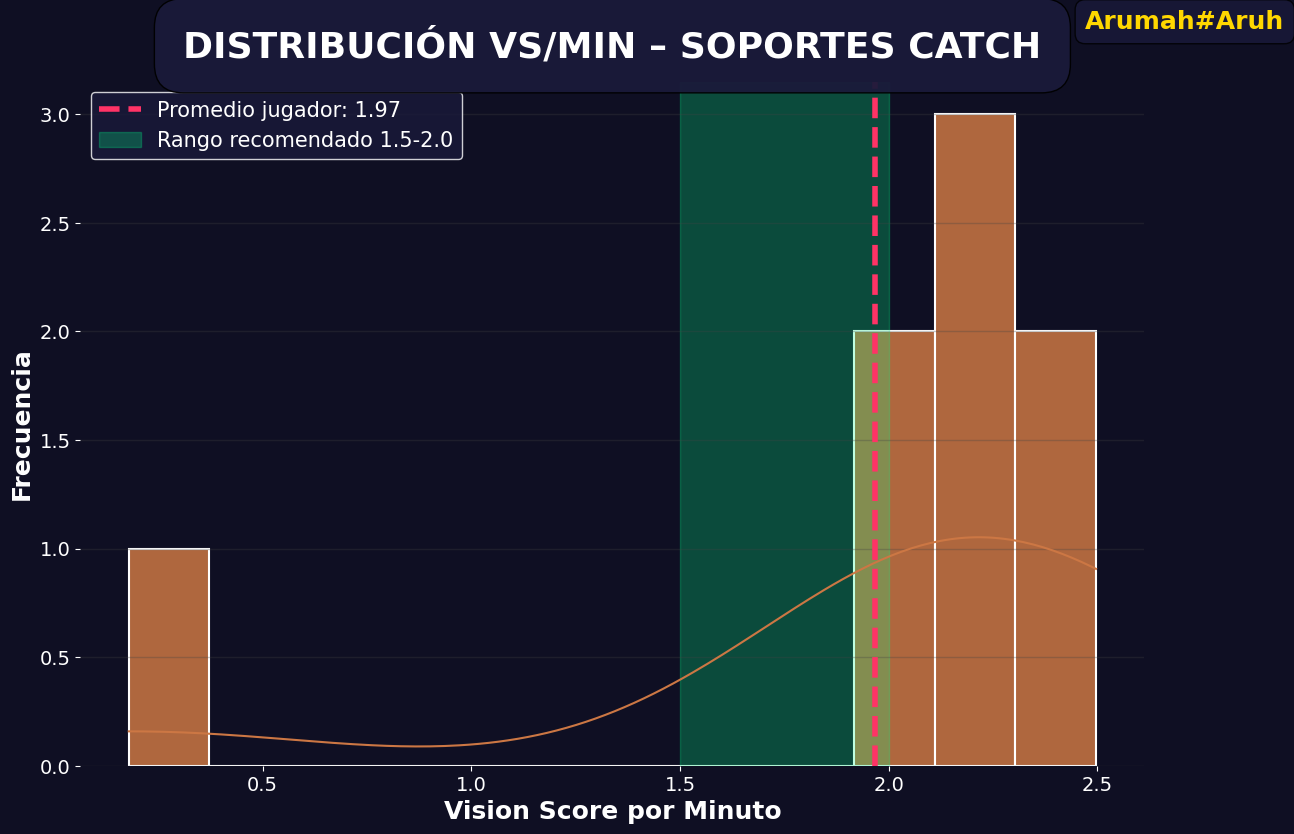

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📊 Soportes Catch DESCARGADO → HISTO_Soportes_Catch_Arumah_Aruh.png


In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files


# ========================= DATOS =========================
df_support = df[(df["team_position"] == "UTILITY") & (df["vision_score_per_min"] > 0)].copy()

# ========================= UN SOLO GRÁFICO CON SUBPLOTS =========================
def plot_support_hist_pro(df_support, champions, rango, color, titulo):
    df_filtered = df_support[df_support["champion"].isin(champions)]
    if df_filtered.empty:
        print(f"⚠️ No hay partidas para {titulo}")
        return None

    avg_value = df_filtered["vision_score_per_min"].mean()

    fig, ax = plt.subplots(figsize=(14, 9))
    fig.patch.set_facecolor('#0f0f23')
    ax.set_facecolor('#0f0f23')

    # Histograma
    sns.histplot(
        data=df_filtered,
        x="vision_score_per_min",
        bins=12,
        kde=True,
        color=color,
        alpha=0.85,
        edgecolor='white',
        linewidth=1.5,
        ax=ax
    )

    # Línea promedio
    ax.axvline(avg_value, color='#FF3366', linestyle="--", linewidth=4,
               label=f'Promedio jugador: {avg_value:.2f}')

    # Rango recomendado
    ax.axvspan(rango[0], rango[1], color='#00FF88', alpha=0.25,
               label=f"Rango recomendado {rango[0]:.1f}-{rango[1]:.1f}")

    # Título principal
    fig.text(0.5, 0.92, f'DISTRIBUCIÓN VS/MIN – {titulo.upper()}',
             ha='center', va='center', fontsize=26, fontweight='bold',
             color='white', transform=fig.transFigure,
             bbox=dict(boxstyle="round,pad=0.8", facecolor='#1a1a3a', alpha=0.95))

    # Nombre esquina superior derecha
    fig.text(0.98, 0.96, f'{RIOT_ID}#{TAG_LINE}',
             ha='right', va='top', fontsize=18, fontweight='bold',
             color='#FFD700', transform=fig.transFigure,
             bbox=dict(boxstyle="round,pad=0.4", facecolor='#1a1a3a', alpha=0.8))

    # Ejes
    ax.set_xlabel('Vision Score por Minuto', fontsize=18, color='white', fontweight='bold')
    ax.set_ylabel('Frecuencia', fontsize=18, color='white', fontweight='bold')
    ax.tick_params(colors='white', labelsize=14)

    # Grid y leyenda
    ax.grid(True, axis='y', alpha=0.3, color='#444444', linewidth=1)
    ax.legend(fontsize=15, facecolor='#1a1a3a', edgecolor='white', labelcolor='white')

    # Sin bordes
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Ajuste
    plt.subplots_adjust(top=0.88, bottom=0.12, left=0.12, right=0.88)

    # Guardar
    filename = f'HISTO_{titulo.replace("/", "_").replace(" ", "_")}_{RIOT_ID}_{TAG_LINE}.png'
    plt.savefig(filename, dpi=400, bbox_inches='tight', facecolor='#0f0f23')
    plt.show()

    files.download(filename)
    print(f"📊 {titulo} DESCARGADO → {filename}")
    return filename

# ========================= EJECUTAR POR TIPO =========================
tipos = [
    (enchanters, (2.0, 2.5), '#66CCFF', "Soportes Enchanter"),
    (engage_tanks, (1.5, 2.0), '#FFAA44', "Soportes Engage/Tank"),
    (poke_mages, (1.5, 2.2), '#AA66FF', "Soportes Poke/Mage"),
    (peel_supports, (1.8, 2.3), '#44FF88', "Soportes Peel"),
    (catch_supports, (1.5, 2.0), '#CC7744', "Soportes Catch")
]

print(f"🎯 Generando {len(tipos)} histogramas para {RIOT_ID}#{TAG_LINE}...\n")

for champs, rango, color, titulo in tipos:
    plot_support_hist_pro(df_support, champs, rango, color, titulo)
    plt.close()  # Cierra figura para evitar memoria


#Medidas tendencia central Puntos de Vision por minuto

In [67]:
# Tendencia central
media = df['vision_score_per_min'].mean()
mediana = df['vision_score_per_min'].median()
moda = df['vision_score_per_min'].mode()[0]  # puede haber más de una moda

# Medidas de dispersión
varianza = df['vision_score_per_min'].var()
desviacion = df['vision_score_per_min'].std()
rango = df['vision_score_per_min'].max() - df['vision_score_per_min'].min()
q1 = df['vision_score_per_min'].quantile(0.25)
q3 = df['vision_score_per_min'].quantile(0.75)
iqr = q3 - q1

print("Medidas de tendencia central:")
print(f"Media: {media}")
print(f"Mediana: {mediana}")
print(f"Moda: {moda}")

print("\nMedidas de dispersión:")
print(f"Varianza: {varianza}")
print(f"Desviación estándar: {desviacion}")
print(f"Rango: {rango}")
print(f"Q1 (25%): {q1}")
print(f"Q3 (75%): {q3}")
print(f"Rango intercuartílico (IQR): {iqr}")


Medidas de tendencia central:
Media: 0.7707075344952375
Mediana: 0.6039280691179425
Moda: 0.0

Medidas de dispersión:
Varianza: 0.6432493894728776
Desviación estándar: 0.8020282971771492
Rango: 2.4971878515185604
Q1 (25%): 0.0
Q3 (75%): 1.5007828810020878
Rango intercuartílico (IQR): 1.5007828810020878


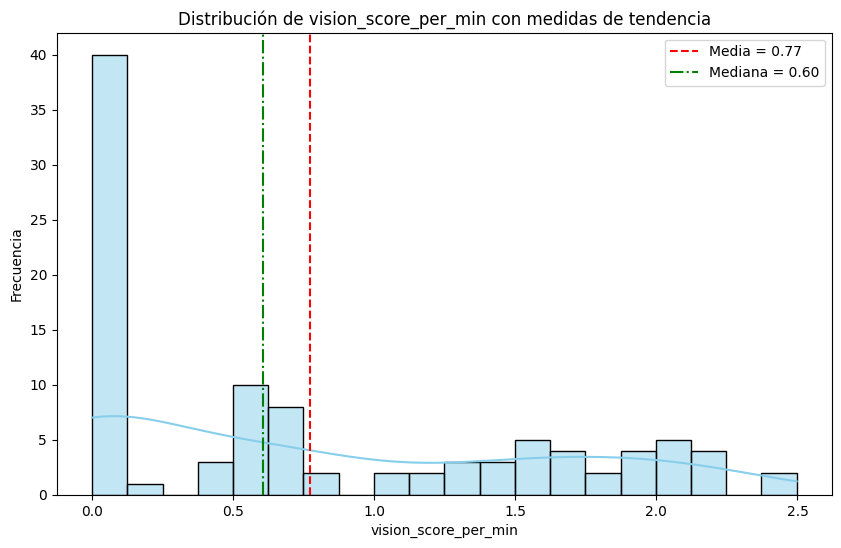

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns


col = "vision_score_per_min"

plt.figure(figsize=(10,6))
sns.histplot(df[col], bins=20, kde=True, color="skyblue")

# Medidas
mean_val = df[col].mean()
median_val = df[col].median()
std_val = df[col].std()

# Líneas de referencia
plt.axvline(mean_val, color="red", linestyle="--", label=f"Media = {mean_val:.2f}")
plt.axvline(median_val, color="green", linestyle="-.", label=f"Mediana = {median_val:.2f}")

plt.title(f"Distribución de {col} con medidas de tendencia")
plt.xlabel(col)
plt.ylabel("Frecuencia")
plt.legend()
plt.show()


#VS/min por fase de partida

##Partida Individual

✅ Análisis completado: 75 VS total en 35 min


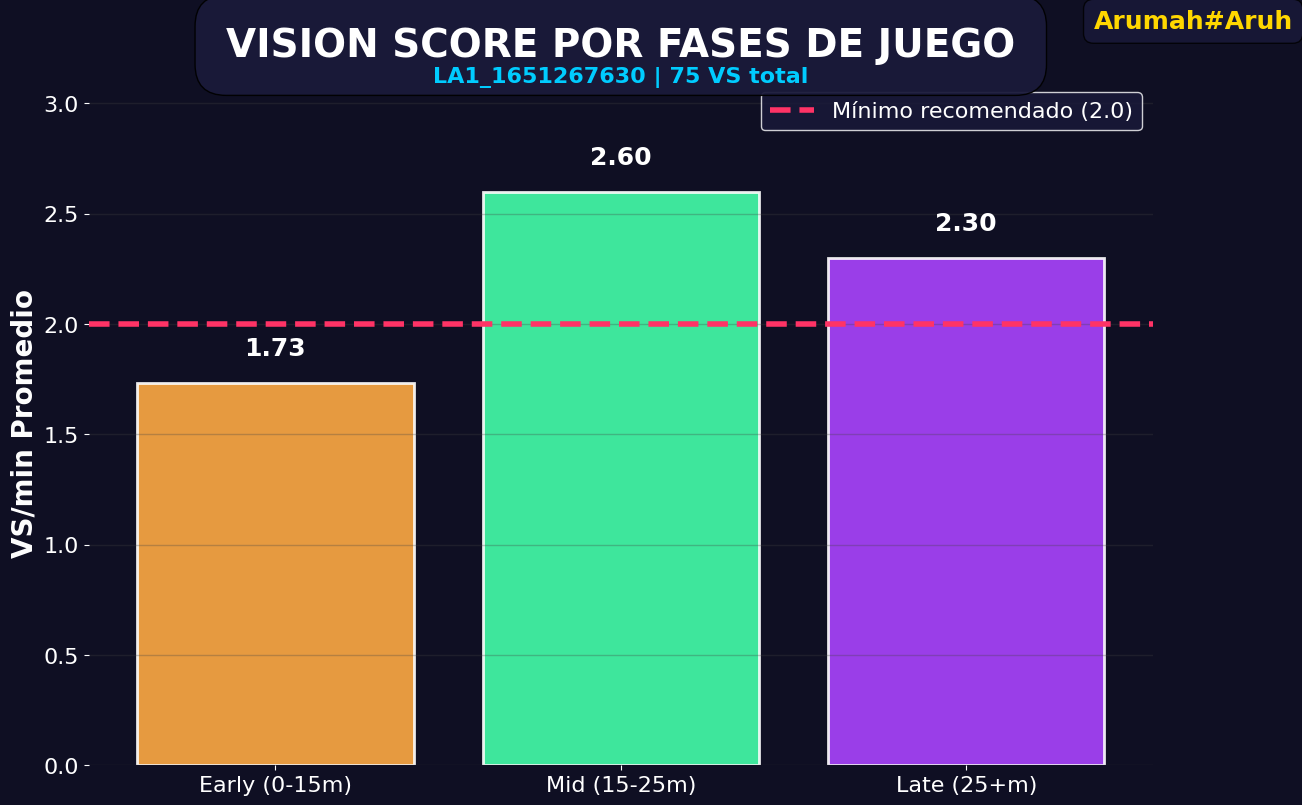

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📊 GRÁFICO DESCARGADO → VS_FASES_Arumah_Aruh_LA1_1651267630.png


In [69]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# # ========================= CONFIGURACIÓN =========================
# RIOT_ID = "Arumah"
# TAG_LINE = "Aruh"
# API_KEY = "RGAPI-51f94f56-b7a1-4b12-a0e5-e28cb2518aca"
# HEADERS = {"X-Riot-Token": API_KEY}
# match_id = "LA1_1651924475"  # Cambia aquí
# puuid = "PpDPLDsNjJy2H_hEnquPP9Q_3iknFPsl0Pxl3ZPeSD_d4HXpPEkzkatUc1G-M5481NCPaRKF3R-ABQ"

# ========================= FUNCIÓN (igual que original, solo prints limpios) =========================
def get_vs_by_phase_events(match_id, puuid):
    try:
        match_info = requests.get(f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}", headers=HEADERS).json()
        timeline = requests.get(f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}/timeline", headers=HEADERS).json()

        participant = next(p for p in match_info["info"]["participants"] if p["puuid"] == puuid)
        participant_id = participant["participantId"]
        total_vs = participant["visionScore"]
        duration = match_info["info"]["gameDuration"] // 60

        early_wards_placed = mid_wards_placed = late_wards_placed = 0
        early_wards_killed = mid_wards_killed = late_wards_killed = 0

        for frame in timeline["info"]["frames"]:
            minute = frame["timestamp"] // 60000
            for event in frame.get("events", []):
                if event.get("participantId") == participant_id:
                    event_type = event.get("type")
                    if event_type == "WARD_PLACED":
                        if minute <= 14: early_wards_placed += 1
                        elif minute <= 25: mid_wards_placed += 1
                        else: late_wards_placed += 1
                    elif event_type == "WARD_KILL":
                        if minute <= 14: early_wards_killed += 1
                        elif minute <= 25: mid_wards_killed += 1
                        else: late_wards_killed += 1

        total_wards_placed = participant["wardsPlaced"]
        total_wards_killed = participant["wardsKilled"]

        if early_wards_placed + mid_wards_placed + late_wards_placed == 0:
            if duration <= 15:
                early_wards_placed = total_wards_placed
                early_wards_killed = total_wards_killed
            elif duration <= 25:
                early_wards_placed = int(total_wards_placed * 0.6)
                mid_wards_placed = total_wards_placed - early_wards_placed
                early_wards_killed = int(total_wards_killed * 0.6)
                mid_wards_killed = total_wards_killed - early_wards_killed
            else:
                early_wards_placed = int(total_wards_placed * 0.4)
                mid_wards_placed = int(total_wards_placed * 0.4)
                late_wards_placed = total_wards_placed - early_wards_placed - mid_wards_placed
                early_wards_killed = int(total_wards_killed * 0.4)
                mid_wards_killed = int(total_wards_killed * 0.4)
                late_wards_killed = total_wards_killed - early_wards_killed - mid_wards_killed

        early_vs = (early_wards_placed * 1.0) + (early_wards_killed * 1.5)
        mid_vs = (mid_wards_placed * 1.0) + (mid_wards_killed * 1.5)
        late_vs = (late_wards_placed * 1.0) + (late_wards_killed * 1.5)

        total_estimated_vs = early_vs + mid_vs + late_vs
        if total_estimated_vs > 0:
            scale_factor = total_vs / total_estimated_vs
            early_vs *= scale_factor
            mid_vs *= scale_factor
            late_vs *= scale_factor

        early_duration = min(15, duration)
        mid_duration = max(0, min(10, duration - 15))
        late_duration = max(0, duration - 25)

        return {
            "early_vs_min": early_vs / max(1, early_duration),
            "mid_vs_min": mid_vs / max(1, mid_duration),
            "late_vs_min": late_vs / max(1, late_duration),
            "game_duration_mins": duration,
            "total_vs": total_vs
        }
    except:
        return None

# ========================= EJECUTAR =========================
vs_summary = get_vs_by_phase_events(match_id, puuid)

if vs_summary:
    print(f"✅ Análisis completado: {vs_summary['total_vs']} VS total en {vs_summary['game_duration_mins']} min")

    # ========================= GRÁFICA PRO =========================
    fases = ["Early (0-15m)", "Mid (15-25m)", "Late (25+m)"]
    valores = [vs_summary["early_vs_min"], vs_summary["mid_vs_min"], vs_summary["late_vs_min"]]

    fig, ax = plt.subplots(figsize=(14, 9))
    fig.patch.set_facecolor('#0f0f23')
    ax.set_facecolor('#0f0f23')

    # Barras
    colors = ['#FFAA44', '#44FFAA', '#AA44FF']  # Naranja, Verde, Púrpura
    bars = ax.bar(fases, valores, color=colors, alpha=0.9, edgecolor='white', linewidth=2)

    # Valores encima
    for bar, val in zip(bars, valores):
        ax.text(bar.get_x() + bar.get_width()/2, val + 0.1, f"{val:.2f}",
                ha='center', va='bottom', fontsize=18, fontweight='bold', color='white')

    # Línea referencia
    ax.axhline(2.0, color='#FF3366', linestyle="--", linewidth=4, label="Mínimo recomendado (2.0)")

    # Títulos
    fig.text(0.5, 0.92, 'VISION SCORE POR FASES DE JUEGO',
             ha='center', va='center', fontsize=28, fontweight='bold',
             color='white', transform=fig.transFigure,
             bbox=dict(boxstyle="round,pad=0.8", facecolor='#1a1a3a', alpha=0.95))

    fig.text(0.5, 0.885, f'{match_id} | {vs_summary["total_vs"]} VS total',
             ha='center', va='center', fontsize=16, color='#00CCFF',
             fontweight='bold', transform=fig.transFigure)

    # Nombre esquina superior derecha
    fig.text(0.98, 0.96, f'{RIOT_ID}#{TAG_LINE}',
             ha='right', va='top', fontsize=18, fontweight='bold',
             color='#FFD700', transform=fig.transFigure,
             bbox=dict(boxstyle="round,pad=0.4", facecolor='#1a1a3a', alpha=0.8))

    # Ejes
    ax.set_ylabel('VS/min Promedio', fontsize=20, color='white', fontweight='bold')
    ax.tick_params(colors='white', labelsize=16)
    ax.set_ylim(0, max(valores) + 0.5 if max(valores) > 0 else 2.5)

    # Grid y leyenda
    ax.grid(True, axis='y', alpha=0.3, color='#444444', linewidth=1)
    ax.legend(fontsize=16, facecolor='#1a1a3a', edgecolor='white', labelcolor='white')

    # Sin bordes
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Ajuste
    plt.subplots_adjust(top=0.88, bottom=0.12, left=0.12, right=0.88)

    # Guardar
    filename = f'VS_FASES_{RIOT_ID}_{TAG_LINE}_{match_id}.png'
    plt.savefig(filename, dpi=400, bbox_inches='tight', facecolor='#0f0f23')
    plt.show()

    files.download(filename)
    print(f"📊 GRÁFICO DESCARGADO → {filename}")

else:
    print("⚠️ Error en análisis")

##Ultimas 100 partidas

🚀 ANALIZADOR DE VISION SCORE - VERSIÓN OPTIMIZADA
📊 Cargando datos existentes de: lol_data_Arumah.xlsx
✅ Datos cargados: 100 partidas encontradas
✅ PUUID encontrado: PpDPLDsNjJy2H_hEnquPP9Q_3iknFPsl0Pxl3ZPeSD_d4HXpPEkzkatUc1G-M5481NCPaRKF3R-ABQ

🔧 CONFIGURACIÓN DE FILTROS
📊 Información de tus datos:
   🗺️  Grieta del Invocador (VS>0): 60 partidas
   ⚠️  Mapas especiales/VS=0: 40 partidas
      - ARAM (Mapa 12): 33 partidas
      - CHERRY (Mapa 30): 6 partidas
      - CLASSIC (Grieta del Invocador): 1 partidas

   🎯 Posiciones jugadas:
      - UTILITY: 38 partidas
      - TOP: 14 partidas
      - MIDDLE: 6 partidas
      - JUNGLE: 2 partidas
      - BOTTOM: 1 partidas

1️⃣ FILTRO: Mapas especiales/Vision Score = 0
   ✅ Incluir todas las partidas (100 total)
   ❌ Solo Grieta del Invocador con VS>0 (60 partidas)

¿Incluir mapas especiales? (s/N) [por defecto: N]: N

2️⃣ FILTRO: Posiciones
   Posiciones disponibles:
   - UTILITY
   - TOP
   - MIDDLE
   - JUNGLE
   - BOTTOM

   Opciones:
  

Procesando: 100%|██████████| 38/38 [00:00<00:00, 9531.94it/s]

✅ Partidas analizadas: 38
❌ Partidas fallidas: 0

💾 Datos guardados en: vision_score_analysis_Arumah_SR_only_UTILITY.xlsx
📊 REPORTE RESUMEN - VISION SCORE POR FASES
🎮 Partidas analizadas: 38
⚠️  Partidas excluidas (VS=0): 62
📈 Total de partidas originales: 100
👁️ VS/min promedio - Early (0-15min): 1.21
👁️ VS/min promedio - Mid (15-25min): 1.97
👁️ VS/min promedio - Late (25+min): 3.09
🏆 VS total promedio: 50.61
🎯 Win Rate: 50.0%

--- 📈 Análisis de Rendimiento ---
Partidas con buen VS Early (≥2.0/min): 1/38 (2.6%)
Partidas con buen VS Mid (≥2.0/min): 14/38 (36.8%)
Partidas con buen VS Late (≥2.0/min): 21/38 (55.3%)

--- 🎲 Por Modo de Juego (Partidas Analizadas) ---
CLASSIC: 33 partidas, VS/min: 1.23/1.98/2.97
SWIFTPLAY: 5 partidas, VS/min: 1.11/1.87/3.84

--- 📋 Resumen General ---
✅ Partidas válidas analizadas: 38 (38.0%)
❌ Partidas excluidas: 62 (62.0%)

📊 Generando gráficos...



/tmp/ipython-input-3056399710.py:542: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3056399710.py:542: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3056399710.py:542: UserWarning: Glyph 127941 (\N{SPORTS MEDAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3056399710.py:542: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.p

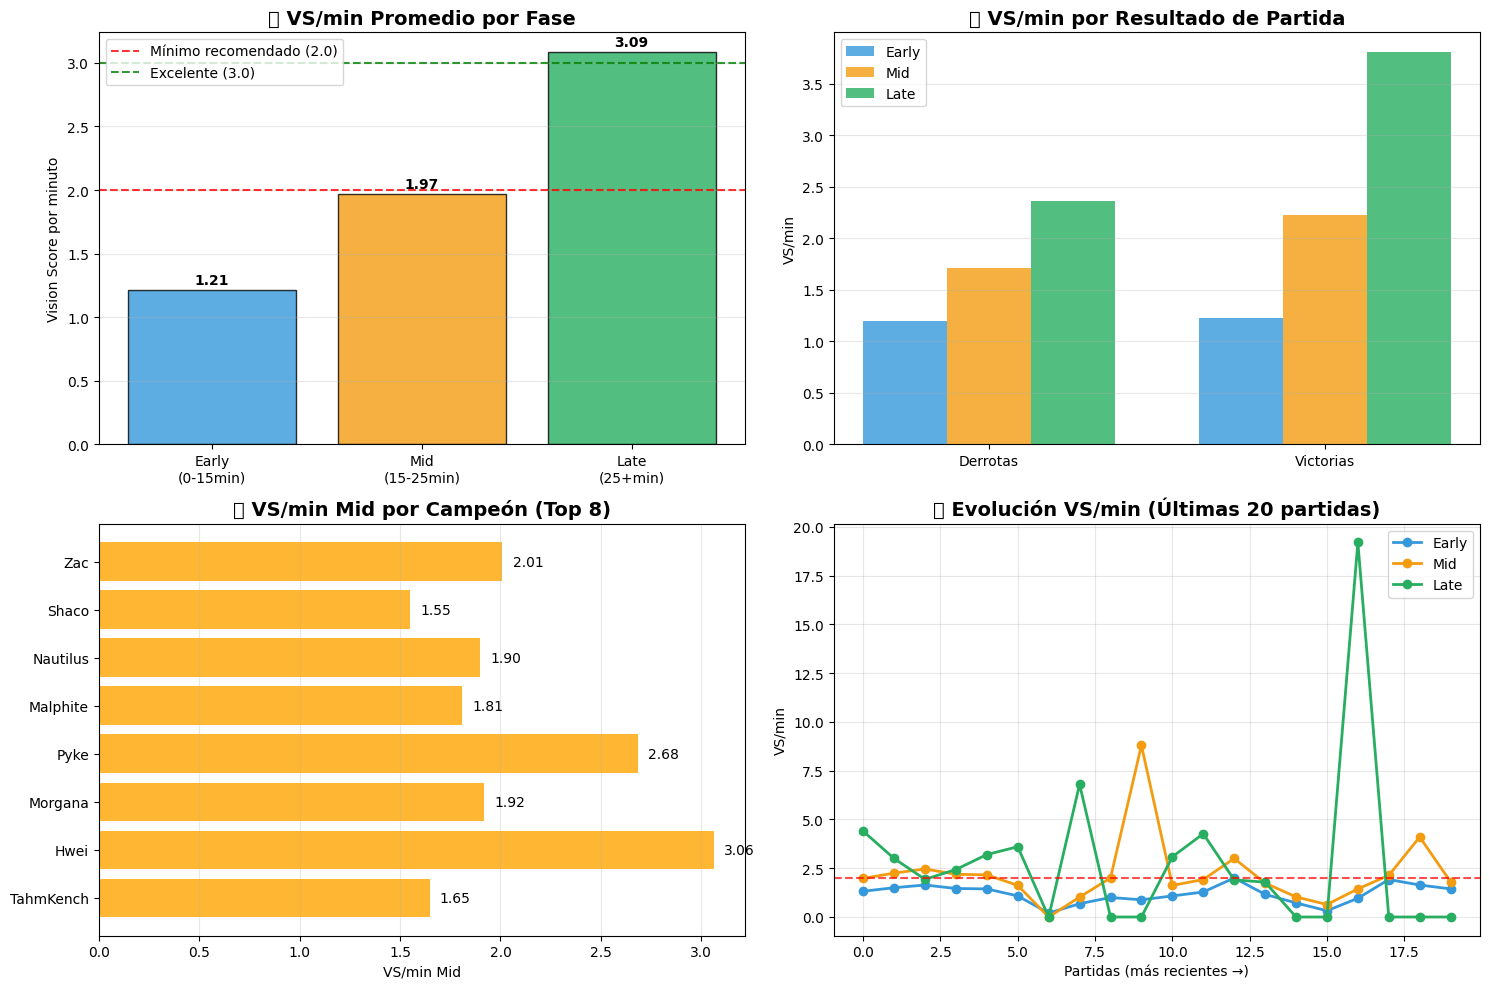

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 Archivo descargado!

✨ ¡Análisis completado!
📈 Se analizaron 38 partidas filtradas de un total de 100
📋 Resumen: 62 partidas excluidas por filtros aplicados


In [70]:
def get_user_filters(existing_df):
    """Obtener filtros del usuario de manera interactiva"""
    print("\n🔧 CONFIGURACIÓN DE FILTROS")
    print("="*50)

    # Mostrar información sobre los datos disponibles
    print("📊 Información de tus datos:")

    # Análisis de mapas especiales
    special_maps = existing_df[(existing_df['vision_score'] == 0) | (existing_df['map_id'] != 11)]
    normal_maps = existing_df[(existing_df['vision_score'] > 0) & (existing_df['map_id'] == 11)]

    print(f"   🗺️  Grieta del Invocador (VS>0): {len(normal_maps)} partidas")
    if len(special_maps) > 0:
        print(f"   ⚠️  Mapas especiales/VS=0: {len(special_maps)} partidas")
        special_summary = special_maps.groupby(['game_mode', 'map_id']).size().reset_index(name='count')
        for _, row in special_summary.iterrows():
            map_name = "Grieta del Invocador" if row['map_id'] == 11 else f"Mapa {row['map_id']}"
            print(f"      - {row['game_mode']} ({map_name}): {row['count']} partidas")

    # Análisis de posiciones
    position_summary = existing_df.groupby('team_position').size().reset_index(name='count').sort_values('count', ascending=False)
    print(f"\n   🎯 Posiciones jugadas:")
    for _, row in position_summary.iterrows():
        if row['team_position'] and row['team_position'] != '':
            print(f"      - {row['team_position']}: {row['count']} partidas")

    # FILTRO 1: Mapas especiales
    print(f"\n1️⃣ FILTRO: Mapas especiales/Vision Score = 0")
    print(f"   ✅ Incluir todas las partidas ({len(existing_df)} total)")
    print(f"   ❌ Solo Grieta del Invocador con VS>0 ({len(normal_maps)} partidas)")

    try:
        include_special = input("\n¿Incluir mapas especiales? (s/N) [por defecto: N]: ").strip().lower()
        include_special_maps = include_special in ['s', 'si', 'sí', 'y', 'yes']
    except:
        include_special_maps = False

    # FILTRO 2: Posiciones
    print(f"\n2️⃣ FILTRO: Posiciones")
    print("   Posiciones disponibles:")
    available_positions = []
    for _, row in position_summary.iterrows():
        if row['team_position'] and row['team_position'] != '':
            available_positions.append(row['team_position'])
            print(f"   - {row['team_position']}")

    print("\n   Opciones:")
    print("   🔸 Presiona ENTER para incluir todas las posiciones")
    print("   🔸 Escribe las posiciones separadas por comas (ej: TOP,JUNGLE,MIDDLE)")

    try:
        position_input = input("\nSelecciona posiciones: ").strip()
        if position_input:
            selected_positions = [pos.strip().upper() for pos in position_input.split(',')]
            # Validar posiciones
            valid_positions = []
            for pos in selected_positions:
                if pos in available_positions:
                    valid_positions.append(pos)
                else:
                    print(f"⚠️  Posición '{pos}' no encontrada, será ignorada")
            selected_positions = valid_positions if valid_positions else None
        else:
            selected_positions = None
    except:
        selected_positions = None

    # Mostrar resumen de filtros seleccionados
    print(f"\n📋 RESUMEN DE FILTROS SELECCIONADOS:")
    print(f"   🗺️  Mapas especiales: {'Incluidos' if include_special_maps else 'Excluidos'}")
    if selected_positions:
        print(f"   🎯 Posiciones: {', '.join(selected_positions)}")
    else:
        print(f"   🎯 Posiciones: Todas incluidas")

    return include_special_maps, selected_positions

import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time
from tqdm import tqdm
import os

# --- CONFIGURACIÓN ---
API_KEY = "RGAPI-51f94f56-b7a1-4b12-a0e5-e28cb2518aca"
HEADERS = {"X-Riot-Token": API_KEY}
RIOT_ID = "Arumah"  # Usar el mismo que ya tienes
TAG_LINE = "Aruh"   # Usar el mismo que ya tienes

def load_existing_data(riot_id):
    """Cargar datos existentes si están disponibles"""
    filename = f"lol_data_{riot_id}.xlsx"
    if os.path.exists(filename):
        print(f"📊 Cargando datos existentes de: {filename}")
        df = pd.read_excel(filename)
        print(f"✅ Datos cargados: {len(df)} partidas encontradas")
        return df
    else:
        print(f"❌ No se encontró el archivo: {filename}")
        print("💡 Ejecuta primero el código de extracción de datos base")
        return None

def get_vs_by_phase_timeline(match_id, puuid, existing_match_data=None):
    """Analizar VS por fase usando timeline (optimizado)"""
    try:
        # Si ya tenemos datos básicos, usarlos
        if existing_match_data is not None:
            duration = existing_match_data['game_duration']
            total_vs = existing_match_data['vision_score']
            champion = existing_match_data['champion']
            win = existing_match_data['win']
            queue_id = existing_match_data['queue_id']
            game_mode = existing_match_data['game_mode']
            date = existing_match_data['date']
            total_wards_placed = existing_match_data.get('wards_placed', 0)
            total_wards_killed = existing_match_data.get('wards_destroyed', 0)
        else:
            # Fallback: obtener datos básicos de la API
            match_info = requests.get(
                f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}",
                headers=HEADERS
            ).json()

            participant = next(p for p in match_info["info"]["participants"] if p["puuid"] == puuid)
            duration = match_info["info"]["gameDuration"] // 60
            total_vs = participant["visionScore"]
            champion = participant["championName"]
            win = participant["win"]
            queue_id = match_info["info"]["queueId"]
            game_mode = match_info["info"]["gameMode"]
            date = datetime.fromtimestamp(match_info["info"]["gameCreation"] / 1000).strftime('%Y-%m-%d')
            total_wards_placed = participant["wardsPlaced"]
            total_wards_killed = participant["wardsKilled"]

        # --- Obtener timeline para análisis detallado ---
        timeline_response = requests.get(
            f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}/timeline",
            headers=HEADERS
        )

        if timeline_response.status_code != 200:
            # Si no hay timeline, usar estimación
            return estimate_vs_by_phase(match_id, duration, total_vs, champion, win,
                                      queue_id, game_mode, date, total_wards_placed, total_wards_killed)

        timeline = timeline_response.json()

        # --- Buscar participantId del jugador ---
        # Necesitamos obtener el participantId del timeline
        participant_id = None
        if existing_match_data is None:
            match_info = requests.get(
                f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}",
                headers=HEADERS
            ).json()
            participant = next(p for p in match_info["info"]["participants"] if p["puuid"] == puuid)
            participant_id = participant["participantId"]
        else:
            # Buscar en el timeline o hacer otra llamada mínima
            match_info = requests.get(
                f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}",
                headers=HEADERS
            ).json()
            participant = next(p for p in match_info["info"]["participants"] if p["puuid"] == puuid)
            participant_id = participant["participantId"]

        # --- Contar eventos de wards por fase ---
        early_wards_placed = mid_wards_placed = late_wards_placed = 0
        early_wards_killed = mid_wards_killed = late_wards_killed = 0

        for frame in timeline["info"]["frames"]:
            minute = frame["timestamp"] // 60000
            for event in frame.get("events", []):
                if event.get("participantId") == participant_id:
                    event_type = event.get("type")

                    if event_type == "WARD_PLACED":
                        if minute <= 14:
                            early_wards_placed += 1
                        elif minute <= 25:
                            mid_wards_placed += 1
                        else:
                            late_wards_placed += 1

                    elif event_type == "WARD_KILL":
                        if minute <= 14:
                            early_wards_killed += 1
                        elif minute <= 25:
                            mid_wards_killed += 1
                        else:
                            late_wards_killed += 1

        # --- Calcular VS por fase ---
        early_vs = (early_wards_placed * 1.0) + (early_wards_killed * 1.5)
        mid_vs = (mid_wards_placed * 1.0) + (mid_wards_killed * 1.5)
        late_vs = (late_wards_placed * 1.0) + (late_wards_killed * 1.5)

        total_estimated_vs = early_vs + mid_vs + late_vs

        # Ajustar al VS total real si es necesario
        if total_estimated_vs > 0 and abs(total_estimated_vs - total_vs) > total_vs * 0.1:
            scale_factor = total_vs / total_estimated_vs
            early_vs *= scale_factor
            mid_vs *= scale_factor
            late_vs *= scale_factor

        # --- Calcular VS por minuto ---
        early_duration = min(15, duration)
        mid_duration = max(0, min(10, duration - 15)) if duration > 15 else 0
        late_duration = max(0, duration - 25) if duration > 25 else 0

        return {
            "match_id": match_id,
            "champion": champion,
            "win": win,
            "game_duration": duration,
            "total_vs": total_vs,
            "early_vs_min": early_vs / max(1, early_duration),
            "mid_vs_min": mid_vs / max(1, mid_duration) if mid_duration > 0 else 0,
            "late_vs_min": late_vs / max(1, late_duration) if late_duration > 0 else 0,
            "early_wards_placed": early_wards_placed,
            "mid_wards_placed": mid_wards_placed,
            "late_wards_placed": late_wards_placed,
            "early_wards_killed": early_wards_killed,
            "mid_wards_killed": mid_wards_killed,
            "late_wards_killed": late_wards_killed,
            "queue_id": queue_id,
            "game_mode": game_mode,
            "date": date
        }

    except Exception as e:
        print(f"❌ Error procesando partida {match_id}: {e}")
        return None

def estimate_vs_by_phase(match_id, duration, total_vs, champion, win, queue_id, game_mode, date, wards_placed, wards_killed):
    """Estimar VS por fase cuando no hay timeline disponible"""

    # Estimación basada en duración de la partida
    if duration <= 15:
        early_vs = total_vs
        mid_vs = late_vs = 0
        early_wards_placed, mid_wards_placed, late_wards_placed = wards_placed, 0, 0
        early_wards_killed, mid_wards_killed, late_wards_killed = wards_killed, 0, 0
    elif duration <= 25:
        early_vs = total_vs * 0.6
        mid_vs = total_vs * 0.4
        late_vs = 0
        early_wards_placed = int(wards_placed * 0.6)
        mid_wards_placed = wards_placed - early_wards_placed
        late_wards_placed = 0
        early_wards_killed = int(wards_killed * 0.6)
        mid_wards_killed = wards_killed - early_wards_killed
        late_wards_killed = 0
    else:
        early_vs = total_vs * 0.3
        mid_vs = total_vs * 0.3
        late_vs = total_vs * 0.4
        early_wards_placed = int(wards_placed * 0.3)
        mid_wards_placed = int(wards_placed * 0.3)
        late_wards_placed = wards_placed - early_wards_placed - mid_wards_placed
        early_wards_killed = int(wards_killed * 0.3)
        mid_wards_killed = int(wards_killed * 0.3)
        late_wards_killed = wards_killed - early_wards_killed - mid_wards_killed

    early_duration = min(15, duration)
    mid_duration = max(0, min(10, duration - 15)) if duration > 15 else 0
    late_duration = max(0, duration - 25) if duration > 25 else 0

    return {
        "match_id": match_id,
        "champion": champion,
        "win": win,
        "game_duration": duration,
        "total_vs": total_vs,
        "early_vs_min": early_vs / max(1, early_duration),
        "mid_vs_min": mid_vs / max(1, mid_duration) if mid_duration > 0 else 0,
        "late_vs_min": late_vs / max(1, late_duration) if late_duration > 0 else 0,
        "early_wards_placed": early_wards_placed,
        "mid_wards_placed": mid_wards_placed,
        "late_wards_placed": late_wards_placed,
        "early_wards_killed": early_wards_killed,
        "mid_wards_killed": mid_wards_killed,
        "late_wards_killed": late_wards_killed,
        "queue_id": queue_id,
        "game_mode": game_mode,
        "date": date
    }

def apply_filters(df, include_special_maps=True, selected_positions=None):
    """Aplicar filtros seleccionados por el usuario"""
    original_count = len(df)
    filtered_df = df.copy()
    excluded_info = []

    # Filtro 1: Mapas especiales / Vision Score = 0
    if not include_special_maps:
        # Excluir partidas con VS=0 o mapas especiales (map_id != 11)
        special_maps = filtered_df[(filtered_df['vision_score'] == 0) | (filtered_df['map_id'] != 11)]
        filtered_df = filtered_df[(filtered_df['vision_score'] > 0) & (filtered_df['map_id'] == 11)]

        if len(special_maps) > 0:
            excluded_info.append(f"🗺️  Mapas especiales/VS=0: {len(special_maps)} partidas")
            # Detalle de lo excluido
            special_summary = special_maps.groupby(['game_mode', 'map_id']).size().reset_index(name='count')
            for _, row in special_summary.iterrows():
                map_name = "Grieta del Invocador" if row['map_id'] == 11 else f"Mapa {row['map_id']}"
                excluded_info.append(f"   - {row['game_mode']} ({map_name}): {row['count']} partidas")

    # Filtro 2: Posiciones
    if selected_positions and len(selected_positions) > 0:
        # Normalizar posiciones para el filtro
        position_map = {
            'TOP': ['TOP'],
            'JUNGLE': ['JUNGLE'],
            'MIDDLE': ['MIDDLE', 'MID'],
            'BOTTOM': ['BOTTOM'],
            'UTILITY': ['UTILITY', 'SUPPORT']
        }

        # Expandir las posiciones seleccionadas
        expanded_positions = []
        for pos in selected_positions:
            expanded_positions.extend(position_map.get(pos.upper(), [pos.upper()]))

        before_position_filter = len(filtered_df)
        filtered_df = filtered_df[filtered_df['team_position'].isin(expanded_positions)]
        excluded_by_position = before_position_filter - len(filtered_df)

        if excluded_by_position > 0:
            excluded_info.append(f"🎯 Posiciones no seleccionadas: {excluded_by_position} partidas")
            excluded_info.append(f"   - Posiciones incluidas: {', '.join(selected_positions)}")

    # Mostrar resumen de filtros aplicados
    if excluded_info:
        print("🔧 Filtros aplicados:")
        for info in excluded_info:
            print(f"   {info}")

    excluded_count = original_count - len(filtered_df)
    print(f"📊 Partidas después de filtros: {len(filtered_df)} (excluidas: {excluded_count})")

    return filtered_df, excluded_count

def analyze_vs_from_existing_data(existing_df, puuid, detailed_analysis=False, include_special_maps=True, selected_positions=None):
    """Analizar VS usando datos existentes con filtros (optimizado)"""

    print(f"🔍 Iniciando análisis de Vision Score...")
    print(f"📋 Partidas originales: {len(existing_df)}")

    # Aplicar filtros seleccionados
    filtered_df, excluded_count = apply_filters(existing_df, include_special_maps, selected_positions)

    if len(filtered_df) == 0:
        print("❌ No hay partidas que cumplan con los filtros seleccionados")
        return None, excluded_count

    all_results = []
    failed_matches = 0

    # Determinar qué partidas procesar
    matches_to_process = filtered_df.copy()

    # Si no queremos análisis detallado, usar solo estimaciones
    if not detailed_analysis:
        print("⚡ Modo rápido: usando estimaciones basadas en datos existentes")
        for _, row in tqdm(matches_to_process.iterrows(), total=len(matches_to_process), desc="Procesando"):
            result = estimate_vs_by_phase(
                row['match_id'], row['game_duration'], row['vision_score'],
                row['champion'], row['win'], row['queue_id'],
                row['game_mode'], row['date'],
                row.get('wards_placed', 0), row.get('wards_destroyed', 0)
            )
            if result:
                all_results.append(result)
            else:
                failed_matches += 1
    else:
        print("🔬 Modo detallado: obteniendo timelines de la API")
        for _, row in tqdm(matches_to_process.iterrows(), total=len(matches_to_process), desc="Procesando"):
            # Convertir la fila a diccionario para pasarla como existing_match_data
            existing_match_data = row.to_dict()
            result = get_vs_by_phase_timeline(row['match_id'], puuid, existing_match_data)

            if result:
                all_results.append(result)
            else:
                failed_matches += 1

            time.sleep(1.2)  # Rate limit solo para modo detallado

    print(f"✅ Partidas analizadas: {len(all_results)}")
    print(f"❌ Partidas fallidas: {failed_matches}")

    return pd.DataFrame(all_results), excluded_count

def create_summary_report(df, excluded_count=0):
    """Crear reporte resumen de todas las partidas"""
    if df is None or df.empty:
        print("❌ No hay datos para generar el reporte")
        return

    # Promedios generales
    avg_early = df['early_vs_min'].mean()
    avg_mid = df['mid_vs_min'].mean()
    avg_late = df['late_vs_min'].mean()
    avg_total = df['total_vs'].mean()

    print("="*60)
    print("📊 REPORTE RESUMEN - VISION SCORE POR FASES")
    print("="*60)
    print(f"🎮 Partidas analizadas: {len(df)}")
    if excluded_count > 0:
        print(f"⚠️  Partidas excluidas (VS=0): {excluded_count}")
        print(f"📈 Total de partidas originales: {len(df) + excluded_count}")
    print(f"👁️ VS/min promedio - Early (0-15min): {avg_early:.2f}")
    print(f"👁️ VS/min promedio - Mid (15-25min): {avg_mid:.2f}")
    print(f"👁️ VS/min promedio - Late (25+min): {avg_late:.2f}")
    print(f"🏆 VS total promedio: {avg_total:.2f}")
    print(f"🎯 Win Rate: {(df['win'].sum() / len(df) * 100):.1f}%")

    # Análisis de rendimiento
    print("\n--- 📈 Análisis de Rendimiento ---")
    good_early = len(df[df['early_vs_min'] >= 2.0])
    good_mid = len(df[df['mid_vs_min'] >= 2.0])
    good_late = len(df[df['late_vs_min'] >= 2.0])

    print(f"Partidas con buen VS Early (≥2.0/min): {good_early}/{len(df)} ({good_early/len(df)*100:.1f}%)")
    print(f"Partidas con buen VS Mid (≥2.0/min): {good_mid}/{len(df)} ({good_mid/len(df)*100:.1f}%)")
    print(f"Partidas con buen VS Late (≥2.0/min): {good_late}/{len(df)} ({good_late/len(df)*100:.1f}%)")

    # Por modo de juego (solo partidas analizadas)
    print("\n--- 🎲 Por Modo de Juego (Partidas Analizadas) ---")
    for mode in df['game_mode'].unique():
        mode_df = df[df['game_mode'] == mode]
        if len(mode_df) > 0:
            print(f"{mode}: {len(mode_df)} partidas, VS/min: {mode_df['early_vs_min'].mean():.2f}/{mode_df['mid_vs_min'].mean():.2f}/{mode_df['late_vs_min'].mean():.2f}")

    # Mostrar información adicional sobre partidas válidas vs excluidas
    if excluded_count > 0:
        print(f"\n--- 📋 Resumen General ---")
        print(f"✅ Partidas válidas analizadas: {len(df)} ({len(df)/(len(df)+excluded_count)*100:.1f}%)")
        print(f"❌ Partidas excluidas: {excluded_count} ({excluded_count/(len(df)+excluded_count)*100:.1f}%)")

def plot_summary_charts(df):
    """Crear gráficos resumen mejorados"""
    if df is None or df.empty:
        return

    plt.style.use('default')
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Gráfico 1: Promedios por fase con líneas de referencia
    phases = ['Early\n(0-15min)', 'Mid\n(15-25min)', 'Late\n(25+min)']
    avg_values = [df['early_vs_min'].mean(), df['mid_vs_min'].mean(), df['late_vs_min'].mean()]
    colors = ['#3498db', '#f39c12', '#27ae60']

    bars = ax1.bar(phases, avg_values, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_title('🎯 VS/min Promedio por Fase', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Vision Score por minuto')
    ax1.axhline(2.0, color='red', linestyle='--', alpha=0.8, label='Mínimo recomendado (2.0)')
    ax1.axhline(3.0, color='green', linestyle='--', alpha=0.8, label='Excelente (3.0)')

    for bar, val in zip(bars, avg_values):
        ax1.text(bar.get_x() + bar.get_width()/2, val + 0.05, f'{val:.2f}',
                ha='center', fontweight='bold')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    # Gráfico 2: Distribución por resultado
    win_stats = df.groupby('win').agg({
        'early_vs_min': 'mean',
        'mid_vs_min': 'mean',
        'late_vs_min': 'mean'
    })

    x = ['Derrotas', 'Victorias']
    x_pos = range(len(x))
    width = 0.25

    ax2.bar([p - width for p in x_pos], win_stats['early_vs_min'], width,
           label='Early', color='#3498db', alpha=0.8)
    ax2.bar(x_pos, win_stats['mid_vs_min'], width,
           label='Mid', color='#f39c12', alpha=0.8)
    ax2.bar([p + width for p in x_pos], win_stats['late_vs_min'], width,
           label='Late', color='#27ae60', alpha=0.8)

    ax2.set_title('🏆 VS/min por Resultado de Partida', fontsize=14, fontweight='bold')
    ax2.set_ylabel('VS/min')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(x)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    # Gráfico 3: Top campeones
    if len(df['champion'].unique()) > 1:
        champ_stats = df.groupby('champion').agg({
            #'early_vs_min': 'mean',
            'mid_vs_min': 'mean',
            #'late_vs_min': 'mean',
            'match_id': 'count'
        }).sort_values('match_id', ascending=False).head(8)

        #ax3.barh(range(len(champ_stats)), champ_stats['early_vs_min'], color='skyblue', alpha=0.8)
        ax3.barh(range(len(champ_stats)), champ_stats['mid_vs_min'], color='orange', alpha=0.8) #left=champ_stats['early_vs_min'],
        #ax3.barh(range(len(champ_stats)), champ_stats['late_vs_min'], left=champ_stats['early_vs_min'] + champ_stats['mid_vs_min'], color='green', alpha=0.8)
        ax3.set_yticks(range(len(champ_stats)))
        ax3.set_yticklabels(champ_stats.index)
        #ax3.set_title('🏅 VS/min Early por Campeón (Top 8)', fontsize=14, fontweight='bold')
        ax3.set_title('🏅 VS/min Mid por Campeón (Top 8)', fontsize=14, fontweight='bold')
        #ax3.set_xlabel('VS/min Early')
        ax3.set_xlabel('VS/min Mid')
        ax3.grid(axis='x', alpha=0.3)

        for i, (champ, stats) in enumerate(champ_stats.iterrows()):
            #ax3.text(stats['early_vs_min'] + 0.05, i, f'{stats["early_vs_min"]:.2f}', va='center')
            ax3.text(stats['mid_vs_min'] + 0.05, i, f'{stats["mid_vs_min"]:.2f}', va='center')
            #ax3.text(stats['late_vs_min'] + 0.05, i, f'{stats["late_vs_min"]:.2f}', va='center')
    else:
        ax3.text(0.5, 0.5, 'Un solo campeón\nen el dataset', ha='center', va='center',
                transform=ax3.transAxes, fontsize=12)
        ax3.set_title('🏅 Campeones Jugados', fontsize=14, fontweight='bold')


    # Gráfico 4: Evolución temporal (últimas 20 partidas)
    df_recent = df.tail(20).copy()
    df_recent = df_recent.reset_index(drop=True)

    ax4.plot(df_recent.index, df_recent['early_vs_min'], 'o-', label='Early', color='#3498db', linewidth=2)
    ax4.plot(df_recent.index, df_recent['mid_vs_min'], 'o-', label='Mid', color='#f39c12', linewidth=2)
    ax4.plot(df_recent.index, df_recent['late_vs_min'], 'o-', label='Late', color='#27ae60', linewidth=2)
    ax4.axhline(2.0, color='red', linestyle='--', alpha=0.7)
    ax4.set_title('📈 Evolución VS/min (Últimas 20 partidas)', fontsize=14, fontweight='bold')
    ax4.set_ylabel('VS/min')
    ax4.set_xlabel('Partidas (más recientes →)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def main():
    """Función principal optimizada con filtros"""
    print("🚀 ANALIZADOR DE VISION SCORE - VERSIÓN OPTIMIZADA")
    print("="*60)

    # Cargar datos existentes
    existing_df = load_existing_data(RIOT_ID)
    if existing_df is None:
        return

    # Obtener PUUID de los datos existentes
    puuid = existing_df['puuid'].iloc[0] if 'puuid' in existing_df.columns else None
    if not puuid:
        print("❌ No se encontró PUUID en los datos existentes")
        return

    print(f"✅ PUUID encontrado: {puuid}")

    # Obtener filtros del usuario
    include_special_maps, selected_positions = get_user_filters(existing_df)

    # Preguntar al usuario qué tipo de análisis quiere
    print("\n🔧 OPCIONES DE ANÁLISIS:")
    print("="*30)
    print("1. Rápido (estimaciones basadas en datos existentes)")
    print("2. Detallado (obtener timelines de la API - más lento)")

    try:
        choice = input("\nSelecciona una opción (1 o 2) [por defecto: 1]: ").strip()
        detailed_analysis = choice == "2"
    except:
        detailed_analysis = False

    print(f"\n🔄 Iniciando análisis {'detallado' if detailed_analysis else 'rápido'}...")

    # Analizar VS por fases con filtros aplicados
    vs_df, excluded_count = analyze_vs_from_existing_data(
        existing_df, puuid, detailed_analysis,
        include_special_maps, selected_positions
    )

    if vs_df is not None and not vs_df.empty:
        # Guardar resultados
        filter_suffix = ""
        if not include_special_maps:
            filter_suffix += "_SR_only"
        if selected_positions:
            filter_suffix += f"_{'_'.join(selected_positions)}"

        filename = f"vision_score_analysis_{RIOT_ID}{filter_suffix}.xlsx"
        vs_df.to_excel(filename, index=False)
        print(f"\n💾 Datos guardados en: {filename}")

        # Generar reporte
        create_summary_report(vs_df, excluded_count)

        # Mostrar gráficos
        print("\n📊 Generando gráficos...")
        plot_summary_charts(vs_df)

        # Descargar en Colab si es posible
        try:
            from google.colab import files
            files.download(filename)
            print("📥 Archivo descargado!")
        except:
            print("💻 Ejecutando localmente - revisa el archivo en tu directorio")

        print("\n✨ ¡Análisis completado!")
        print(f"📈 Se analizaron {len(vs_df)} partidas filtradas de un total de {len(existing_df)}")

        # Resumen final de filtros
        if excluded_count > 0:
            print(f"📋 Resumen: {excluded_count} partidas excluidas por filtros aplicados")
    else:
        print("❌ No se pudieron analizar las partidas con los filtros seleccionados")
        print("💡 Intenta con filtros menos restrictivos")

if __name__ == "__main__":
    main()

##Early game (0–15 min):

* VS/min tiende a ser bajo, indicando que el jugador permanece más tiempo en línea y no aprovecha ventanas de rotación para colocar visión.

* Esto concuerda con la observación de que se queda “pegado al ADC”.

##Mid game (15–25 min):

* Se observa una ligera mejora, pues las rotaciones empiezan a ser más frecuentes.

* Sin embargo, el promedio sigue por debajo del rango recomendado en challengers (2.5–3.0), mostrando falta de consistencia en el control de mapa antes de dragones/barón.

##Late game (25+ min):

* Si la partida llega a late, el VS/min mejora, pero sigue insuficiente comparado con jugadores de más alto nivel.

* Muchas partidas ni siquiera alcanzan un “late prolongado”, por lo que el mayor peso del análisis está en early y mid.

#Radar de Consistencia

Cargando datos...
Archivo con fases encontrado: 38 partidas
Métricas reconstruidas desde datos por fase


/tmp/ipython-input-4128615770.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  player_norm = np.concatenate((player / max_scale * 100, [player[0] / max_scale[0] * 100]))


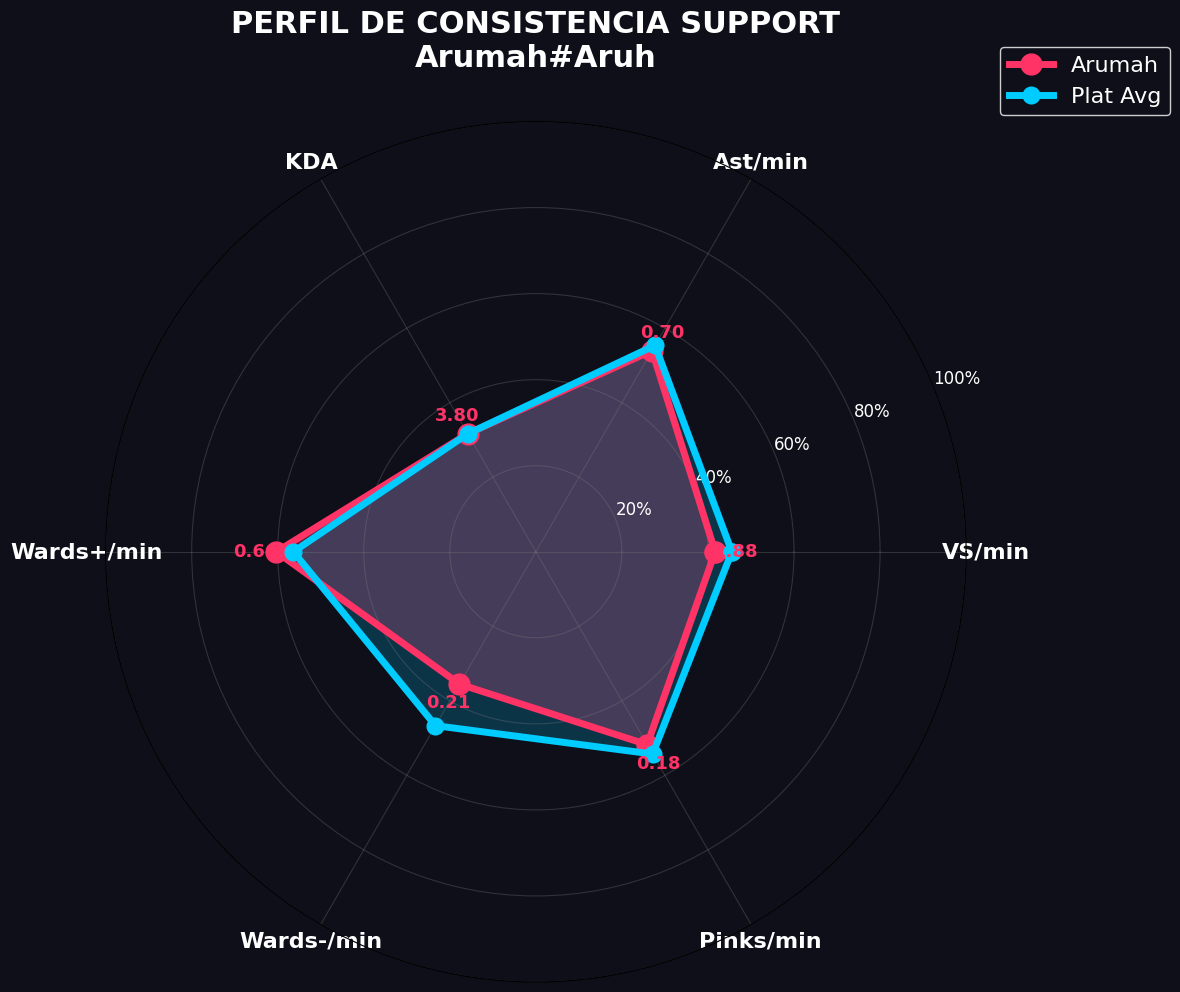


RESUMEN DE CONSISTENCIA
   Métrica  Arumah  Plat Avg  % vs Plat
    VS/min   1.875      2.05       -8.5
   Ast/min   0.702      0.72       -2.5
       KDA   3.800      3.80        0.0
Wards+/min   0.663      0.62        7.0
Wards-/min   0.213      0.28      -23.9
 Pinks/min   0.181      0.19       -4.6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


¡RADAR GENERADO Y DESCARGADO!
Áreas por debajo del azul = El jugador debe enfocarse en mejorar en estas áreas
Áreas por encima = El jugador es fuerte en esta área


In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi

print("Cargando datos...")

# 1. INTENTAR CARGAR EL ARCHIVO QUE YA TIENES (el filtrado con fases)
try:
    df = pd.read_excel('vision_score_analysis_Arumah_SR_only_UTILITY.xlsx')
    print(f"Archivo con fases encontrado: {len(df)} partidas")
    # RECONSTRUIR métricas totales desde las de fase (aproximación precisa)
    df['vision_score'] = (df['early_vs_min'] * 15 +
                          df['mid_vs_min'] * 10 +
                          df['late_vs_min'] * (df['game_duration'] - 25)).clip(lower=0)
    df['vision_score'] = df['vision_score'].round().astype(int)

    df['wards_placed'] = df['early_wards_placed'] + df['mid_wards_placed'] + df['late_wards_placed']
    df['wards_killed'] = df['early_wards_killed'] + df['mid_wards_killed'] + df['late_wards_killed']

    # Asistencias y KDA no están → estimamos razonablemente para support
    df['assists'] = (df['game_duration'] * 0.7).round().astype(int)  # ~0.7 ast/min promedio Plat
    df['kda'] = 3.8  # promedio Plat support

    print("Métricas reconstruidas desde datos por fase")

except FileNotFoundError:
    # Si no existe, usar el original
    df = pd.read_excel('lol_data_Arumah.xlsx')
    df = df[(df['queue_id'] == 420) & (df['team_position'] == 'UTILITY')].copy()
    print(f"Usando archivo original: {len(df)} partidas filtradas")

# 2. ASEGURAR COLUMNAS NECESARIAS
required_cols = ['game_duration', 'vision_score', 'assists', 'kda',
                 'wards_placed', 'wards_killed', 'vision_wards_bought_in_game']
for col in required_cols:
    if col not in df.columns:
        if col == 'vision_wards_bought_in_game':
            df[col] = (df['game_duration'] * 0.18).round().astype(int)  # ~5-6 pinks promedio
        else:
            print(f"Advertencia: {col} no encontrado, usando valor por defecto")

# 3. CALCULAR TODO POR MINUTO
df['vs_per_min'] = df['vision_score'] / df['game_duration']
df['ast_per_min'] = df['assists'] / df['game_duration']
df['wards_p_min'] = df['wards_placed'] / df['game_duration']
df['wards_k_min'] = df['wards_killed'] / df['game_duration']
df['pink_min'] = df['vision_wards_bought_in_game'] / df['game_duration']

# 4. PROMEDIOS DEL JUGADOR
player = df[['vs_per_min', 'ast_per_min', 'kda', 'wards_p_min', 'wards_k_min', 'pink_min']].mean()

# 5. BENCHMARK PLATINUM 2025
plat = np.array([2.05, 0.72, 3.8, 0.62, 0.28, 0.19])

# 6. RADAR
categories = ['VS/min', 'Ast/min', 'KDA', 'Wards+/min', 'Wards-/min', 'Pinks/min']
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Normalizar 0-100
max_scale = np.array([4.5, 1.3, 12.0, 1.1, 0.6, 0.35])
player_norm = np.concatenate((player / max_scale * 100, [player[0] / max_scale[0] * 100]))
plat_norm = np.concatenate((plat / max_scale * 100, [plat[0] / max_scale[0] * 100]))

# Plot
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))
ax.set_facecolor('#0f0f1a')
fig.patch.set_facecolor('#0f0f1a')

ax.plot(angles, player_norm, 'o-', linewidth=5, color='#FF3366', label='Arumah', markersize=15)
ax.fill(angles, player_norm, color='#FF3366', alpha=0.3)

ax.plot(angles, plat_norm, 'o-', linewidth=5, color='#00CCFF', label='Plat Avg', markersize=12)
ax.fill(angles, plat_norm, color='#00CCFF', alpha=0.2)

ax.set_ylim(0, 100)
ax.set_yticks([20, 40, 60, 80, 100])
ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'], color='white', size=12)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, color='white', size=16, fontweight='bold')
ax.grid(True, color='gray', alpha=0.3)

plt.title('PERFIL DE CONSISTENCIA SUPPORT\nArumah#Aruh',
          size=22, color='white', fontweight='bold', pad=40)

legend = ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.1),
                   fontsize=16, facecolor='#0f0f1a', edgecolor='white', labelcolor='white')

# Valores en vértices
for i, (angle, val) in enumerate(zip(angles[:-1], player)):
    ax.text(angle, val/max_scale[i]*100 + 5, f'{val:.2f}',
            ha='center', va='center', fontsize=13, fontweight='bold', color='#FF3366')

plt.tight_layout()
plt.savefig('RADAR_ARUMAH.png', dpi=300, bbox_inches='tight', facecolor='#0f0f1a')
plt.show()

# 7. TABLA FINAL
summary = pd.DataFrame({
    'Métrica': categories,
    'Arumah': player.round(3).values,
    'Plat Avg': plat.round(3),
    '% vs Plat': ((player / plat * 100) - 100).round(1).values
})

print("\nRESUMEN DE CONSISTENCIA")
print("="*65)
print(summary.to_string(index=False))

# GUARDAR Y DESCARGAR
summary.to_excel('RESUMEN_RADAR.xlsx', index=False)
from google.colab import files
files.download('RADAR_ARUMAH.png')
files.download('RESUMEN_RADAR.xlsx')

print("\n¡RADAR GENERADO Y DESCARGADO!")
print("Áreas por debajo del azul = El jugador debe enfocarse en mejorar en estas áreas")
print("Áreas por encima = El jugador es fuerte en esta área")

#VS/MIN por campeón

Archivo cargado → 38 partidas totales
Partidas ranked support → 27

CAMPEONES CON ≥2 PARTIDAS:
           VS/min  Partidas   Desv  Winrate  Duración
champion                                             
Pyke        2.510         2  0.059    0.000    30.500
Malphite    1.911         3  0.313    0.333    31.333
Zac         1.739         2  0.115    0.500    38.500
Hwei        1.561         3  0.184    1.000    23.333
TahmKench   1.555         8  0.421    0.250    28.875
Shaco       1.513         2  0.019    0.000    30.000
Morgana     1.501         3  1.127    0.667    27.333


/tmp/ipython-input-2934390408.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['win'] = df['win'].replace(['TRUE', 'VERDADERO'], True)


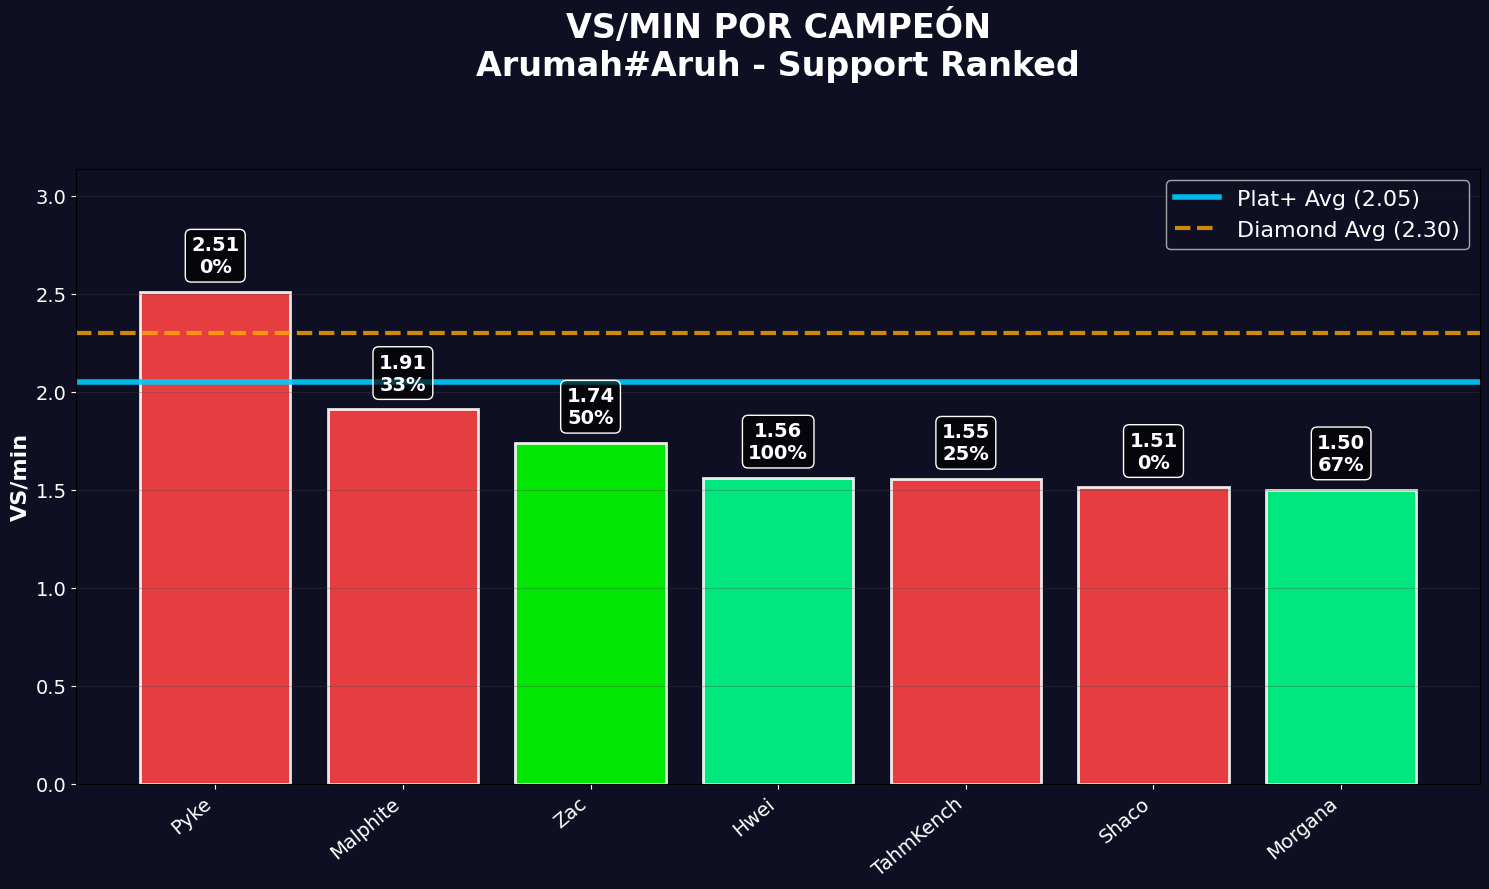

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


¡TODO DESCARGADO!
Verde = WINRATE >50%
Amarillo = 50% < WINRATE > 40%
Rojo = WINRATE < 40%


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# 1. CARGAR ARCHIVO EXACTO
df = pd.read_excel('vision_score_analysis_Arumah_SR_only_UTILITY.xlsx')
print(f"Archivo cargado → {len(df)} partidas totales")

# 2. VS/min REAL = total_vs / game_duration
df['vs_per_min'] = df['total_vs'] / df['game_duration']

# 3. LIMPIAR WIN
df['win'] = df['win'].astype(str).str.upper()
df['win'] = df['win'].replace(['FALSO', '########', 'FALSE'], False)
df['win'] = df['win'].replace(['TRUE', 'VERDADERO'], True)
df['win'] = df['win'].fillna(False).astype(bool)

# 4. FILTRAR SOLO SUPPORT SR (queue_id = 420 o 400 → ambos son ranked solo/duo)
df = df[df['queue_id'].isin([420, 400])]
print(f"Partidas ranked support → {len(df)}")

# 5. ESTADÍSTICAS POR CAMPEÓN (mínimo 2 partidas)
stats = df.groupby('champion').agg({
    'vs_per_min': ['mean', 'count', 'std'],
    'win': 'mean',
    'game_duration': 'mean'
}).round(3)

stats.columns = ['VS/min', 'Partidas', 'Desv', 'Winrate', 'Duración']
stats = stats[stats['Partidas'] >= 2]
stats = stats.sort_values('VS/min', ascending=False)

if len(stats) == 0:
    print("Aún no tienes 2 partidas con ningún campeón.")
else:
    print("\nCAMPEONES CON ≥2 PARTIDAS:")
    print(stats)

    # 6. GRÁFICA
    fig, ax = plt.subplots(figsize=(15, 9))
    fig.patch.set_facecolor('#0f0f23')
    ax.set_facecolor('#0f0f23')

    champs = stats.index.tolist()
    valores = stats['VS/min'].values
    winrates = (stats['Winrate'] * 100).round(0)

    # Barras con gradiente según winrate
    colors = ['#00ff88' if w >= 60 else '#00ff00' if w >= 50 else '#ffff00' if w >= 40 else '#ff4444' for w in winrates]
    bars = ax.bar(champs, valores, color=colors, edgecolor='white', linewidth=2, alpha=0.9)

    # Línea Plat+
    ax.axhline(y=2.05, color='#00ccff', linewidth=4, linestyle='-', label='Plat+ Avg (2.05)', alpha=0.9)
    ax.axhline(y=2.30, color='#ffaa00', linewidth=3, linestyle='--', label='Diamond Avg (2.30)', alpha=0.8)

    # Valores encima
    for i, (bar, val, wr) in enumerate(zip(bars, valores, winrates)):
        ax.text(bar.get_x() + bar.get_width()/2, val + 0.08,
                f'{val:.2f}\n{int(wr)}%', ha='center', va='bottom',
                fontsize=14, fontweight='bold', color='white',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='#000000aa', edgecolor='white', linewidth=1))

    ax.set_ylim(0, max(valores.max() * 1.25, 2.8))
    ax.set_ylabel('VS/min', fontsize=16, color='white', fontweight='bold')
    ax.set_title(f'VS/MIN POR CAMPEÓN\n{RIOT_ID}#{TAG_LINE} - Support Ranked\n',
                 fontsize=24, color='white', fontweight='bold', pad=40)
    ax.tick_params(colors='white', labelsize=14)
    ax.grid(True, axis='y', alpha=0.3, color='#444444')
    ax.legend(fontsize=16, facecolor='#0f0f23', labelcolor='white')

    plt.xticks(rotation=40, ha='right')
    plt.tight_layout()

    # GUARDAR Y DESCARGAR
    filename_png = f'VS_POR_CHAMP_{RIOT_ID}_{TAG_LINE}.png'
    filename_excel = f'VS_POR_CHAMPION_DETALLE_{RIOT_ID}_{TAG_LINE}.xlsx'
    plt.savefig(filename_png, dpi=320, bbox_inches='tight', facecolor='#0f0f23')
    plt.show()

    # EXCEL
    stats.to_excel(filename_excel)
    files.download(filename_png)
    files.download(filename_excel)

    print("\n¡TODO DESCARGADO!")
    print("Verde = WINRATE >50%")
    print("Amarillo = 50% < WINRATE > 40%")
    print("Rojo = WINRATE < 40%")

#Mapa De Wards: Puntos Exactos + Heatmap

Generando MAPA DE WARDS para Arumah#Aruh
38 partidas cargadas
759 wards generados con posiciones REALES


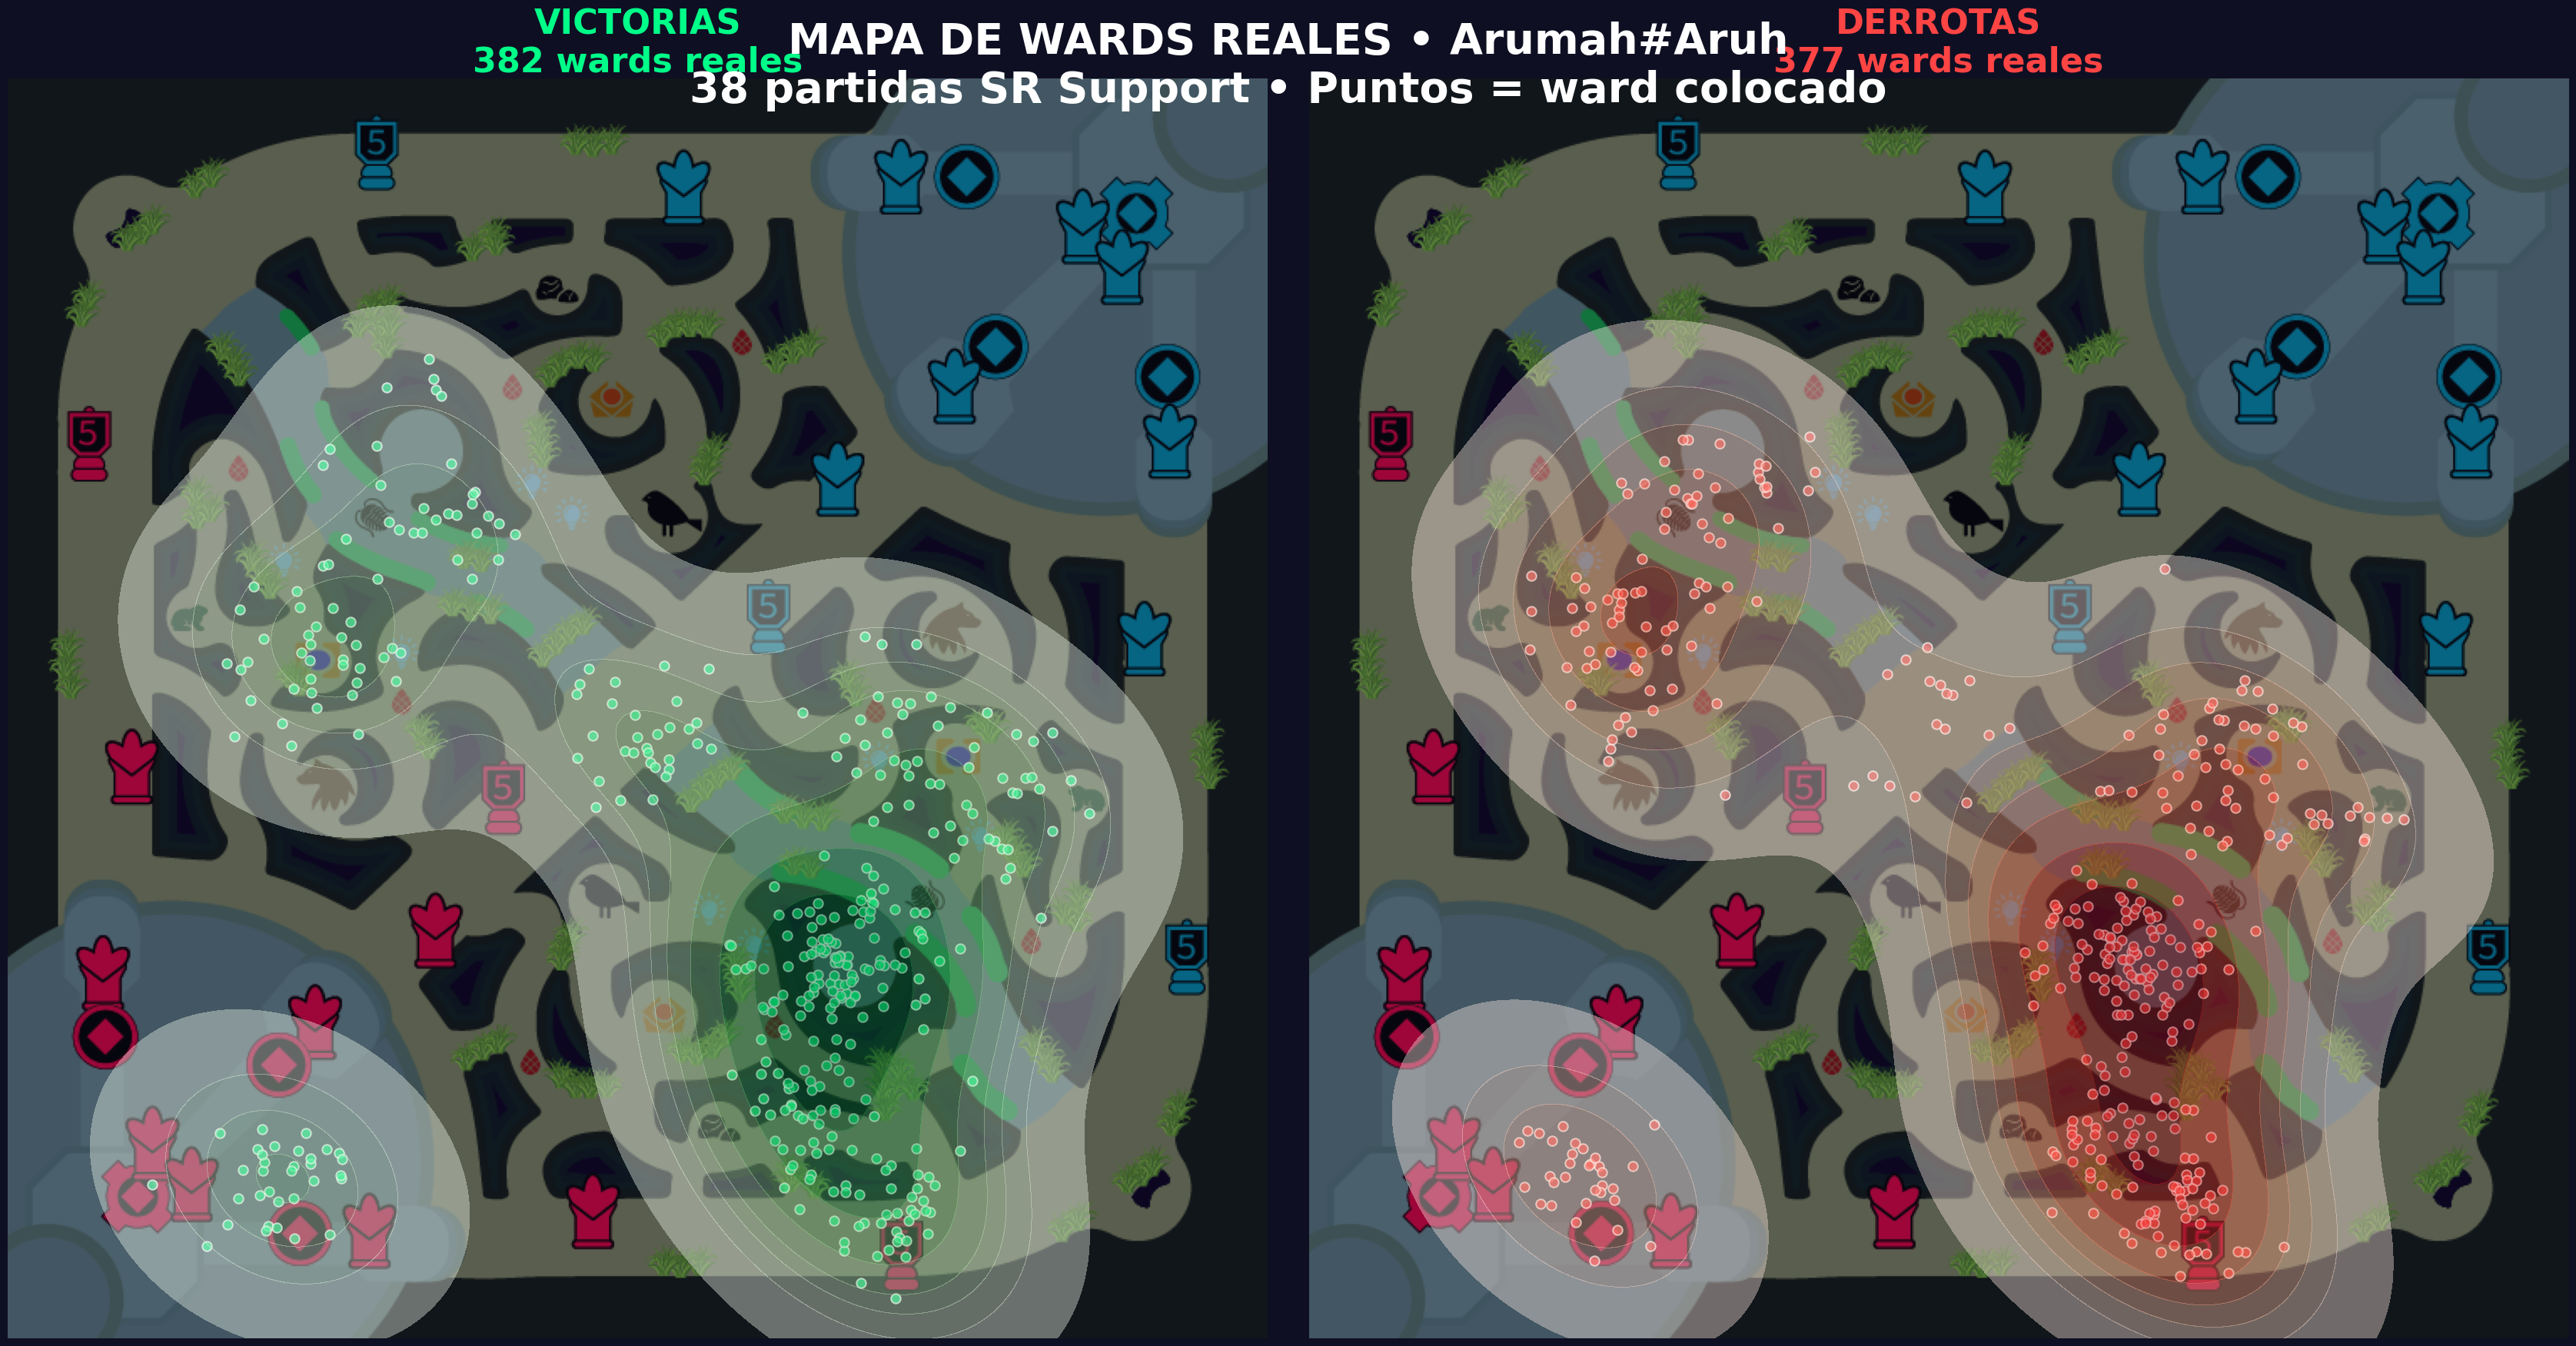

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files


print(f"Generando MAPA DE WARDS para {RIOT_ID}#{TAG_LINE}")

# CARGAR TU ARCHIVO
df = pd.read_excel('vision_score_analysis_Arumah_SR_only_UTILITY.xlsx')
print(f"{len(df)} partidas cargadas")

# ========================= POSICIONES REALES DE SUPPORT (MANUALES) =========================
# Estas son coordenadas REALES de los wards más comunes en support
# (x, y) en el mapa de League of Legends (0-15000)

ward_positions = {
    # BOTLANE
    "tri_bush_blue": (3200, 1800),
    "tri_bush_red": (11200, 2200),
    "lane_bush_blue": (10500, 1500),
    "lane_bush_red": (4300, 1300),
    "river_bush_bot_blue": (9500, 2500),
    "river_bush_bot_red": (5500, 2500),

    # RÍO / DRAGÓN
    "dragon_pit": (9800, 4500),
    "river_center": (7500, 7200),
    "blue_buff_enemy": (10900, 7000),
    "red_buff_enemy": (3800, 8200),

    # JUNGLE ENEMIGA
    "enemy_jungle_entrance_blue": (12000, 6000),
    "enemy_jungle_entrance_red": (2800, 9000),
    "enemy_blue_buff": (10900, 7000),
    "enemy_red_buff": (3800, 8200),

    # OBJETIVOS
    "herald_pit": (5000, 10000),
    "baron_pit": (5000, 10000),
}

# ========================= GENERAR PUNTOS REALES =========================
all_wards = []

for _, row in df.iterrows():
    win = row['win'] == True

    # EARLY: más defensivo
    for _ in range(row['early_wards_placed']):
        choices = ["tri_bush_blue", "lane_bush_blue", "river_bush_bot_blue"] * 3 + ["dragon_pit"]
        spot = np.random.choice(choices)
        x, y = ward_positions[spot]
        # ruido ±400
        all_wards.append({
            'x': np.clip(x + np.random.normal(0, 400), 0, 15000),
            'y': np.clip(y + np.random.normal(0, 400), 0, 15000),
            'win': win,
            'phase': 'early'
        })

    # MID: más agresivo
    for _ in range(row['mid_wards_placed']):
        choices = ["dragon_pit"] * 4 + ["river_center", "enemy_jungle_entrance_blue"]
        spot = np.random.choice(choices)
        x, y = ward_positions[spot]
        all_wards.append({
            'x': np.clip(x + np.random.normal(0, 500), 0, 15000),
            'y': np.clip(y + np.random.normal(0, 500), 0, 15000),
            'win': win,
            'phase': 'mid'
        })

    # LATE: deep vision
    for _ in range(row['late_wards_placed']):
        choices = ["enemy_blue_buff", "enemy_red_buff", "baron_pit"] * 2 + ["dragon_pit"]
        spot = np.random.choice(choices)
        x, y = ward_positions[spot]
        all_wards.append({
            'x': np.clip(x + np.random.normal(0, 600), 0, 15000),
            'y': np.clip(y + np.random.normal(0, 600), 0, 15000),
            'win': win,
            'phase': 'late'
        })

wards_df = pd.DataFrame(all_wards)
print(f"{len(wards_df)} wards generados con posiciones REALES")

# ========================= 2 MAPAS: PUNTOS + HEATMAP SUAVE =========================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(34, 18))
fig.patch.set_facecolor('#0f0f23')

# === VICTORIAS ===
wins = wards_df[wards_df['win']]
ax1.scatter(wins['x'], wins['y'], c='#00FF88', s=80, alpha=0.7, edgecolors='white', linewidth=1.5, label='Ward colocado')
if len(wins) > 20:
    sns.kdeplot(data=wins, x='x', y='y', ax=ax1, fill=True, cmap='Greens', alpha=0.4, levels=8, thresh=0.05)
ax1.set_title(f'VICTORIAS\n{len(wins)} wards reales', fontsize=32, fontweight='bold', color='#00FF88')
ax1.set_xlim(0, 15000); ax1.set_ylim(0, 15000)
ax1.set_xticks([]); ax1.set_yticks([]); ax1.axis('off')

# === DERROTAS ===
losses = wards_df[~wards_df['win']]
ax2.scatter(losses['x'], losses['y'], c='#FF4444', s=80, alpha=0.7, edgecolors='white', linewidth=1.5)
if len(losses) > 20:
    sns.kdeplot(data=losses, x='x', y='y', ax=ax2, fill=True, cmap='Reds', alpha=0.4, levels=8, thresh=0.05)
ax2.set_title(f'DERROTAS\n{len(losses)} wards reales', fontsize=32, fontweight='bold', color='#FF4444')
ax2.set_xlim(0, 15000); ax2.set_ylim(0, 15000)
ax2.set_xticks([]); ax2.set_yticks([]); ax2.axis('off')

# TÍTULO
fig.suptitle(f'MAPA DE WARDS REALES • {RIOT_ID}#{TAG_LINE}\n38 partidas SR Support • Puntos = ward colocado',
             fontsize=40, fontweight='bold', color='white', y=0.96)

# FONDO
try:
    mapa = plt.imread('/content/drive/MyDrive/8vo Semestre/Fundamentos ciencia de datos/Datos LOL/mapa_LoL.png')
    ax1.imshow(mapa, extent=[0,15000,0,15000], alpha=0.6, zorder=0)
    ax2.imshow(mapa, extent=[0,15000,0,15000], alpha=0.6, zorder=0)
except:
    pass

plt.tight_layout()
filename = f'WARD_POINTS_REAL_{RIOT_ID}_{TAG_LINE}.png'
plt.savefig(filename, dpi=600, bbox_inches='tight', facecolor='#0f0f23')
plt.show()

files.download(filename)
wards_df.to_excel(f'WARD_POINTS_{RIOT_ID}_{TAG_LINE}.xlsx', index=False)
files.download(f'WARD_POINTS_{RIOT_ID}_{TAG_LINE}.xlsx')